In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
# from tqdm import tqdm
from pprint import pprint
from src.stereo_calibration_utils import *
from src.cameras import *
%load_ext autoreload
%autoreload 2

# Camera Manager Class
Here we want a manager class to hold the seen markers through the tracker cameras, the time stamps of the observations and the parameters of the camera.

In [3]:
calib_data = '/media/robocaster/13a60227-5511-4ad6-893b-dd4e8545305b/aras-cam-dataset/raw-dataset/uwb_dataset/uwb_jul29/ir_tracker_calibration/recorded-2021-12-02-12:52:00_input.pckl'

cam_dm = cameraDataManager(calib_data, 
                           'sample_dataset/intrinsics/',ports = [5000, 5001, 5002], data_idx= 3)  

synchronized_paths = cam_dm.getSyncronizedSamples('5002-0')
synchronized_paths.keys()

dict_keys(['5000-0', '5000-1', '5001-0', '5001-1', '5002-0', '5002-1'])

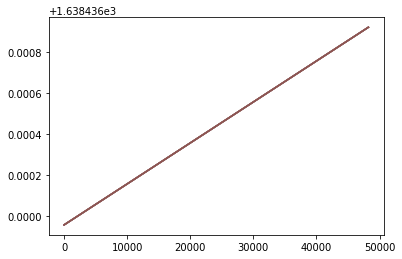

In [4]:
for key in cam_dm.pixel_locations.keys():
    plt.plot(cam_dm.stamp_per_camera[key][cam_dm.syncMap('5002-0',key)[:,1]])

# Calibration

## Compute the Extrinsics Between all Pairs

We have a set of cameras with each pair making a stereo vision system. For the first step, we use the epipolar constraints beween each of these pairs to compute the unscaled extrinsics (relative poses) of each camera pair with respect to each other. Then, we will use factor graph optimization and the GTSAM solver to run a bundle adjustment and refine the paramters.

### Geometrical Identification

The geometric solution of the extrinsics calibration is based on estimating the fundamental and essantial metrices that correspond to an identical marker observed by two cameras while undergoing various locations during a calibration data gathering phase. 

First, let's make a list of all the possible camera pairs. We distinguish each camera node in the system with *port_number-camera_id* designators where *camera_port* is the UDP port from which we recived the marker locations and the *camera_id* is the camera number transmitted over that port. 

In [49]:
cam_keys = [key for key in cam_dm.pixel_locations.keys()]
pairs = []
for i in range(len(cam_keys)-1):
    for j in range(i+1, len(cam_keys)):
#         if cam_keys[i] !='5000-0' and cam_keys[j] !='5000-0':
        pairs.append([cam_keys[i], cam_keys[j]])
pairs

[['5000-0', '5000-1'],
 ['5000-0', '5001-0'],
 ['5000-0', '5001-1'],
 ['5000-0', '5002-0'],
 ['5000-0', '5002-1'],
 ['5000-1', '5001-0'],
 ['5000-1', '5001-1'],
 ['5000-1', '5002-0'],
 ['5000-1', '5002-1'],
 ['5001-0', '5001-1'],
 ['5001-0', '5002-0'],
 ['5001-0', '5002-1'],
 ['5001-1', '5002-0'],
 ['5001-1', '5002-1'],
 ['5002-0', '5002-1']]

the product turned out negative
['5000-0', '5000-1']


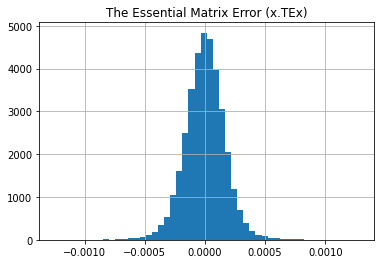

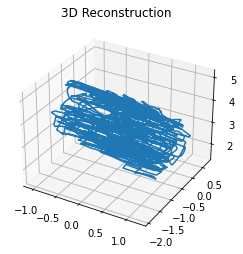

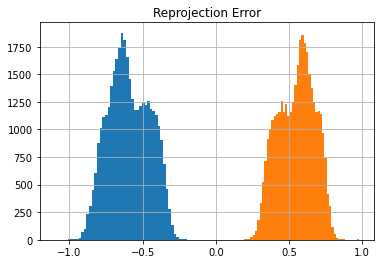

-----------------------------------------
the product turned out negative
['5000-0', '5001-0']


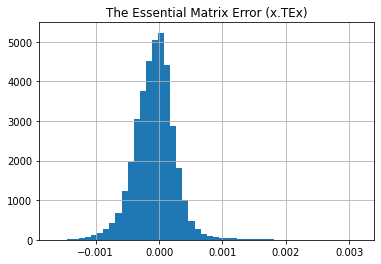

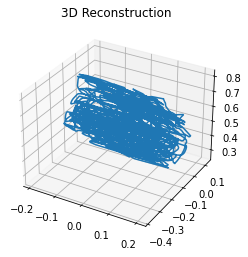

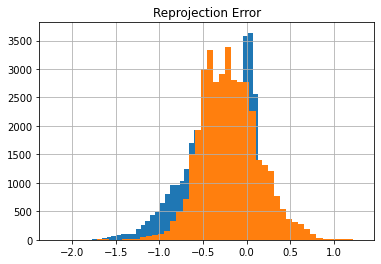

-----------------------------------------
['5000-0', '5001-1']


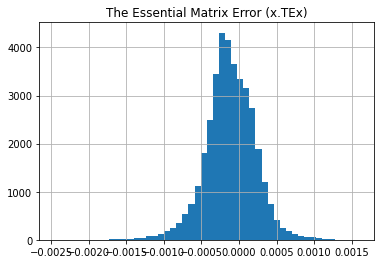

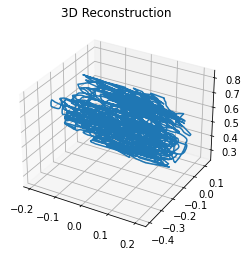

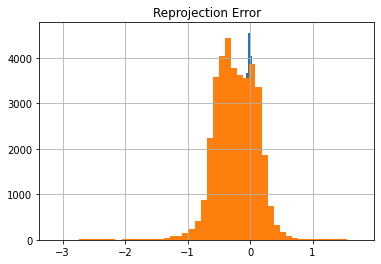

-----------------------------------------
['5000-0', '5002-0']


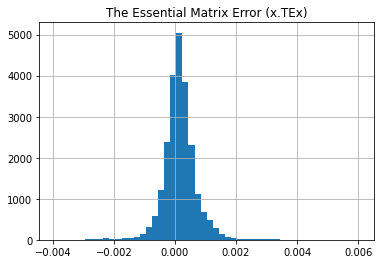

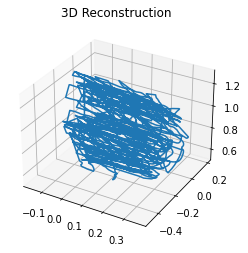

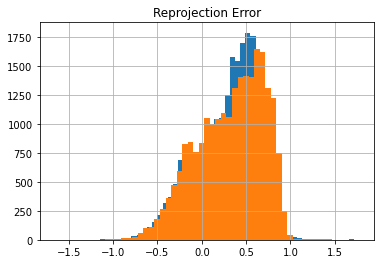

-----------------------------------------
['5000-0', '5002-1']


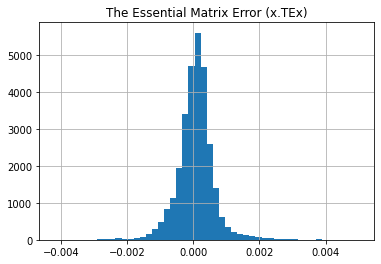

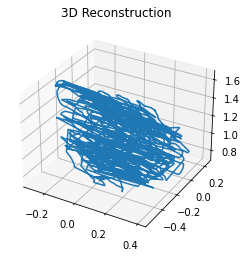

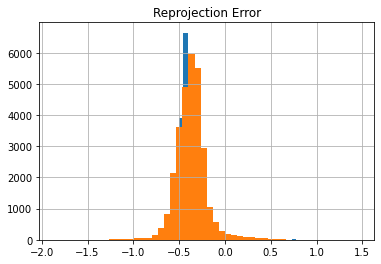

-----------------------------------------
the product turned out negative
['5000-1', '5001-0']


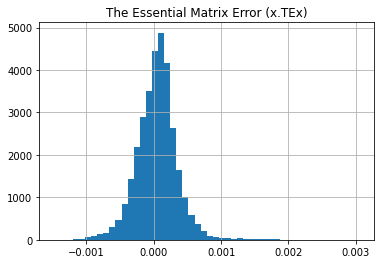

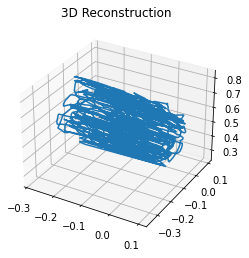

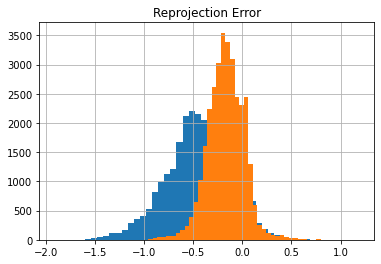

-----------------------------------------
the product turned out negative
['5000-1', '5001-1']


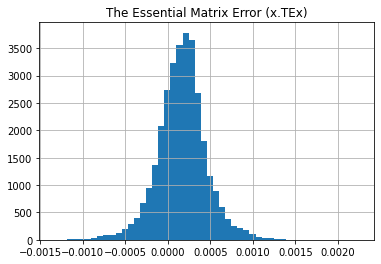

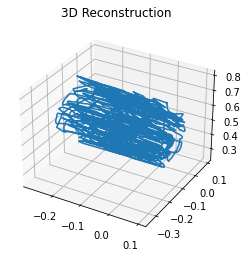

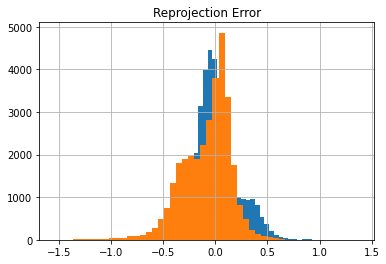

-----------------------------------------
['5000-1', '5002-0']


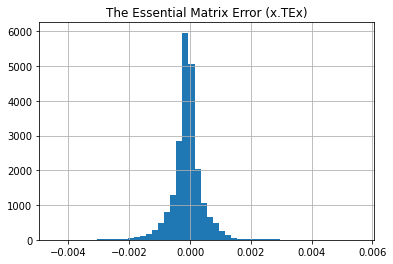

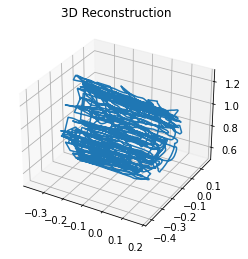

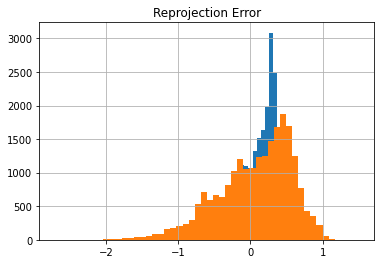

-----------------------------------------
['5000-1', '5002-1']


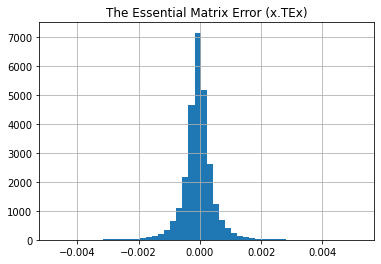

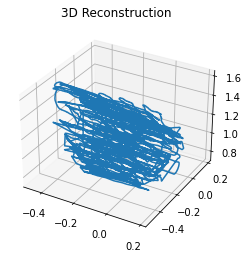

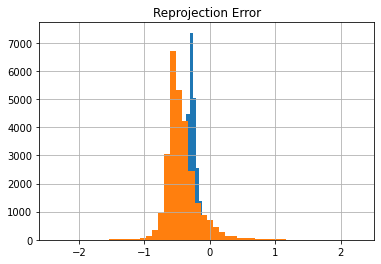

-----------------------------------------
['5001-0', '5001-1']


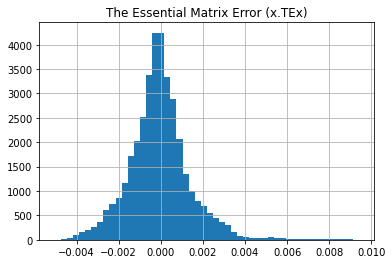

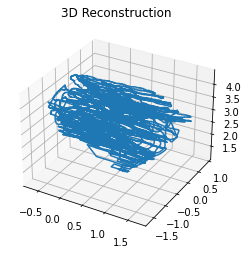

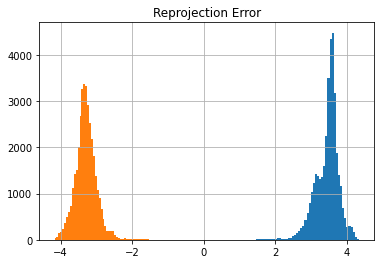

-----------------------------------------
the product turned out negative
['5001-0', '5002-0']


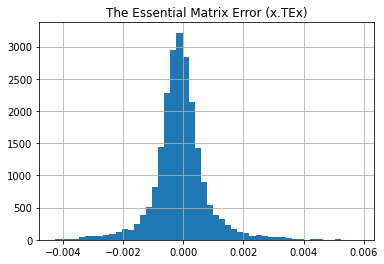

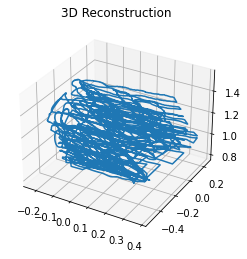

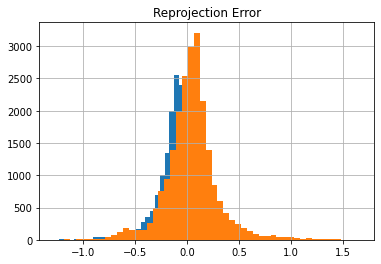

-----------------------------------------
['5001-0', '5002-1']


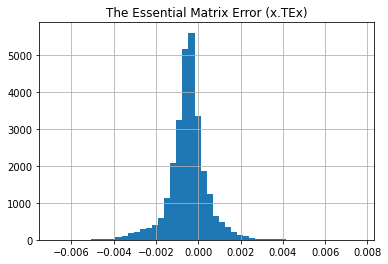

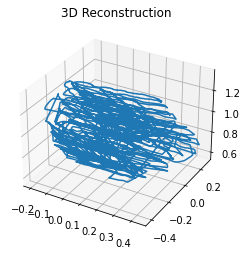

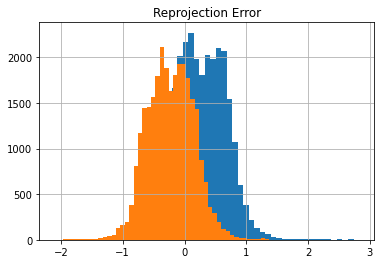

-----------------------------------------
['5001-1', '5002-0']


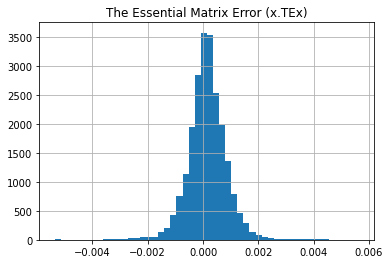

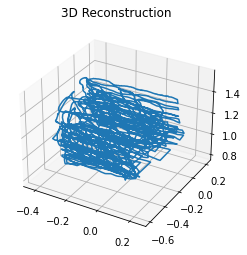

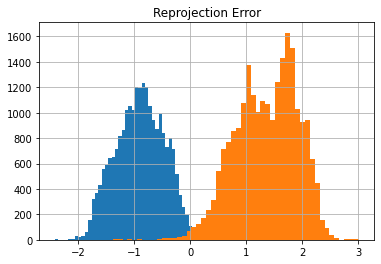

-----------------------------------------
the product turned out negative
['5001-1', '5002-1']


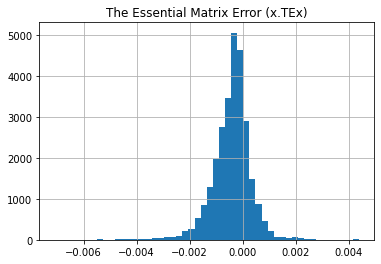

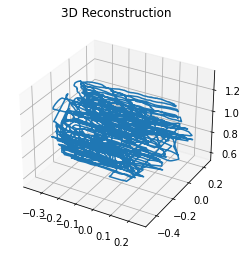

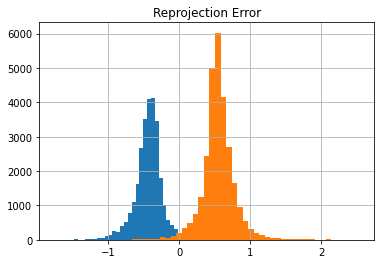

-----------------------------------------
the product turned out negative
['5002-0', '5002-1']


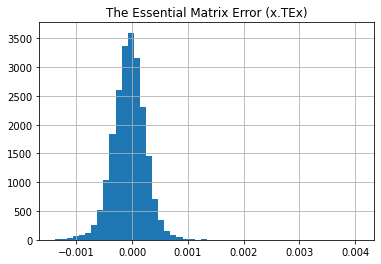

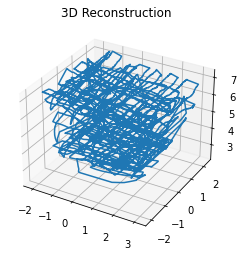

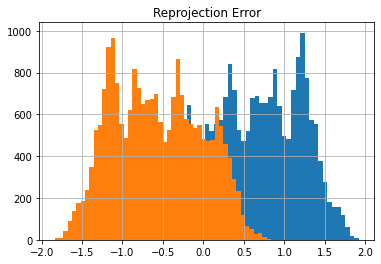

-----------------------------------------


In [6]:
root = 'sample_dataset/pair_extrinsics/geometrical/'
plots_root = 'sample_dataset/plots/stereo_pairs/geometrical/'

gm_ext = StereoGeometricalCalibrator(cam_data_manager=cam_dm)

for pair in pairs:
    c1, c2 = pair
    #Compute the stereo extrinsics
    K1, K2, E, P1, P2, R, t, points_normalized, error, p1_pix, p2_pix = gm_ext.getExtrinsics(c1,c2)
    params={
        'K1':K1, 
        'K2':K2,
        'E':E,
        'P1':P1,
        'P2':P2,
        'R|T':(R,t),
        'E_error': error,
        'landmarks': points_normalized
    }
    with open(os.path.join(root, f'ext_{c1}->{c2}.pckl'),'wb') as f:
        pickle.dump(params, f)

    print(pair)
    _ = plt.hist(error, bins = 50)
    plt.grid(True)
    plt.title('The Essential Matrix Error (x.TEx)')
    plt.savefig(os.path.join(plots_root, f'essential_mat_error_{c1}->{c2}.png'))
    plt.show()

    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2])
    plt.grid(True)
    plt.title('3D Reconstruction')
    plt.savefig(os.path.join(plots_root, f'3d_reconstruction_{c1}->{c2}.png'))
    plt.show()
    # Reprojection Statistics
    reprojected1=np.dot(P1,points_normalized.T)
    reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])

    reprojected2=np.dot(P2,points_normalized.T)
    reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])
    plt.figure()
    _ = plt.hist(np.mean(reprojected1[:,0:2]-p1_pix, axis=-1), bins=50)
    _ = plt.hist(np.mean(reprojected2[:,0:2]-p2_pix, axis=-1), bins=50)
    plt.grid(True)
    plt.title('Reprojection Error')
    plt.savefig(os.path.join(plots_root, f'reprojection_error_{c1}->{c2}.png'))
    plt.show()
    print('-----------------------------------------')


### Calibration Refinement with BA
Based on the geometrical extrinsics from the previous section, we initilize a factor graph and run a bundle adjustment problem to refine and improve the extrinsic calibration of the stereo pairs.

['5000-0', '5000-1']


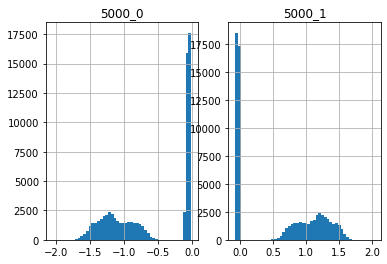

5217.911270389837
Extrinsics Before:
[[ 0.99214823  0.0894791  -0.08738068  0.99606465]
 [-0.08765838  0.99585015  0.02446384 -0.05878409]
 [ 0.08920706 -0.0166121   0.99587456  0.06632982]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.99210871 -0.08763118  0.08967204 -0.9981917 ]
 [ 0.08979904  0.99575043 -0.02042588 -0.03425745]
 [-0.08750103  0.02831716  0.99576187  0.04415848]
 [ 0.          0.          0.          1.        ]]


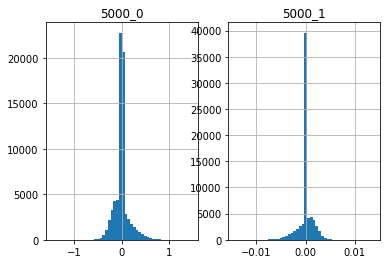

-----------------------------------------
['5000-0', '5001-0']


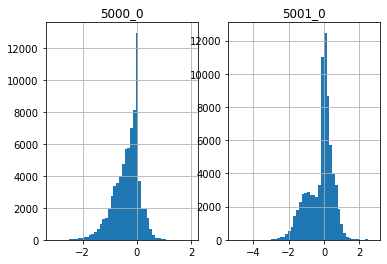

105.19844672409846
Extrinsics Before:
[[-0.99982066 -0.00281473  0.01872788  0.08365375]
 [ 0.01493117  0.49115347  0.87094508 -0.51031119]
 [-0.01164974  0.87106851 -0.49102336  0.85591152]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.99977623  0.01895639 -0.00938815  0.10138217]
 [ 0.00109795  0.48970814  0.87188573 -0.4972304 ]
 [ 0.02112526  0.87168033 -0.48961938  0.86167331]
 [ 0.          0.          0.          1.        ]]


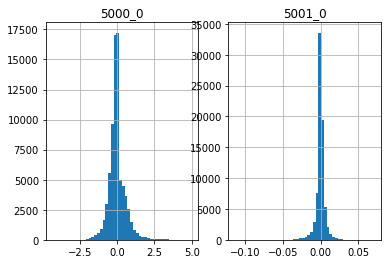

-----------------------------------------
['5000-0', '5001-1']


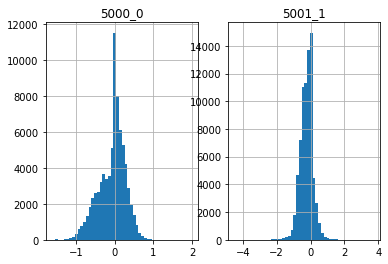

3351.9427071089567
Extrinsics Before:
[[-0.98607386 -0.07490846  0.14848254 -0.07866734]
 [ 0.0964005   0.47007498  0.87734626 -0.50352146]
 [-0.13551858  0.879442   -0.45630744  0.86039386]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.98604879  0.10144307 -0.13197381  0.08644981]
 [-0.06977261  0.46794395  0.88099957 -0.52706489]
 [ 0.15112765  0.87791672 -0.45433762  0.84541685]
 [ 0.          0.          0.          1.        ]]


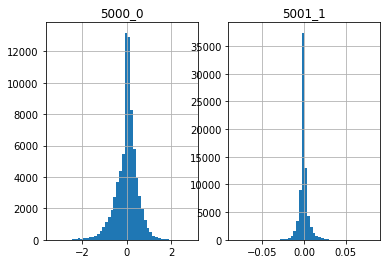

-----------------------------------------
['5000-0', '5002-0']


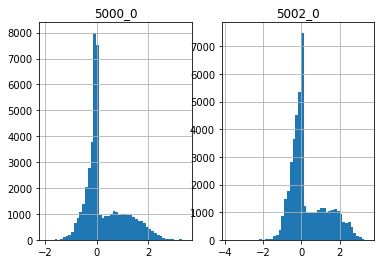

4052.536047905594
Extrinsics Before:
[[ 0.06425631 -0.99592339  0.06330657  0.06653134]
 [ 0.48989611  0.0867481   0.86745408 -0.73812946]
 [-0.86940953 -0.02472576  0.4934731   0.6713706 ]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.06435098  0.48617973 -0.87148621  0.94273039]
 [-0.9960975   0.08415439 -0.02660477  0.14679721]
 [ 0.06040469  0.86979728  0.48969783  0.29941981]
 [ 0.          0.          0.          1.        ]]


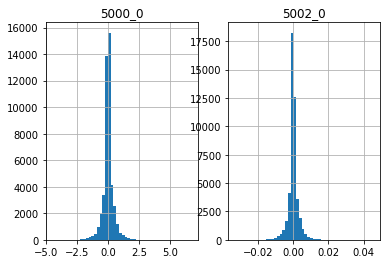

-----------------------------------------
['5000-0', '5002-1']


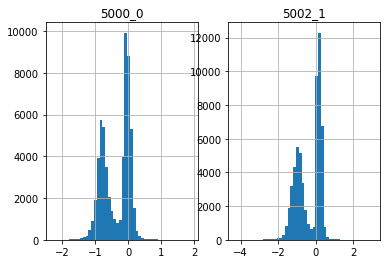

6782.048011865733
Extrinsics Before:
[[ 0.07651614 -0.99566873  0.05281161  0.08414559]
 [ 0.46645354  0.08255917  0.88068444 -0.7643164 ]
 [-0.88123003 -0.04275241  0.47075031  0.63932774]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.07383373  0.46767207 -0.88081293  0.91352857]
 [-0.99567683  0.0844822  -0.0386059   0.17259343]
 [ 0.05635811  0.87985544  0.47188788  0.3683408 ]
 [ 0.          0.          0.          1.        ]]


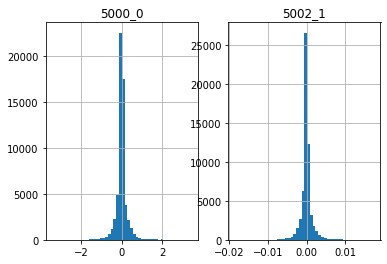

-----------------------------------------
['5000-1', '5001-0']


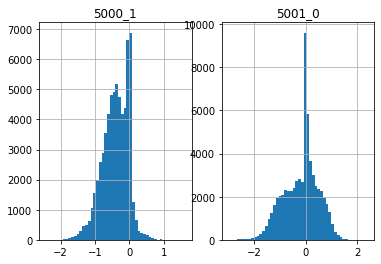

1746.9652713846117
Extrinsics Before:
[[-0.99486147  0.02638926 -0.09774589  0.03663572]
 [-0.07388047  0.47089568  0.87908983 -0.52842119]
 [ 0.06922665  0.88179412 -0.46652632  0.84819153]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.99504108 -0.06799376  0.07259542 -0.06174323]
 [ 0.03194633  0.47272028  0.88063328 -0.49962702]
 [-0.09419489  0.87858544 -0.46820395  0.86403766]
 [ 0.          0.          0.          1.        ]]


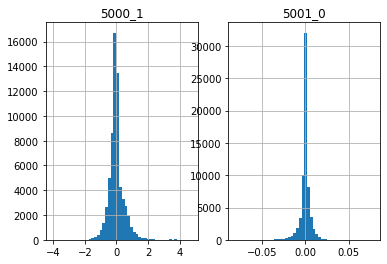

-----------------------------------------
['5000-1', '5001-1']


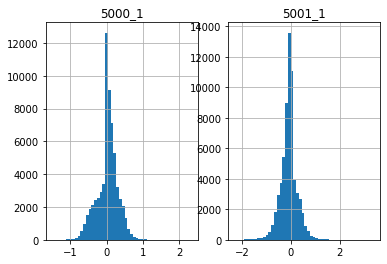

1914.3204784726095
Extrinsics Before:
[[-0.99868802 -0.03876604  0.03345795 -0.12522571]
 [ 0.01258526  0.44752498  0.89418287 -0.52064581]
 [-0.04963719  0.8934308  -0.44644995  0.8445392 ]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.99876469  0.01503093 -0.04736209 -0.07774874]
 [-0.03574104  0.44486406  0.89488465 -0.52658097]
 [ 0.03452064  0.89547196 -0.4437773   0.84656228]
 [ 0.          0.          0.          1.        ]]


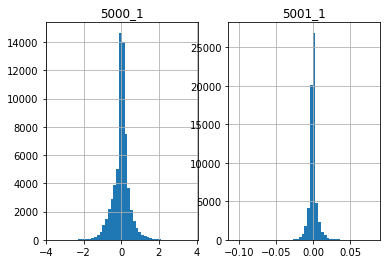

-----------------------------------------
['5000-1', '5002-0']


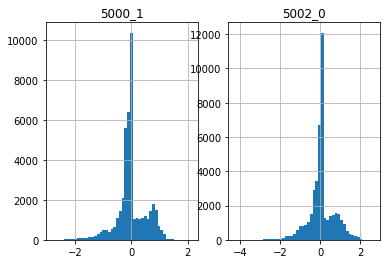

766.144189793888
Extrinsics Before:
[[-5.33736850e-02 -9.98102621e-01  3.06986483e-02 -1.00847118e-01]
 [ 5.06512618e-01 -5.66151091e-04  8.62232363e-01 -7.47604359e-01]
 [-8.60579001e-01  6.15697713e-02  5.05581790e-01  6.56443129e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Extrinsics After:
[[-5.29639612e-02  5.02983369e-01 -8.62671750e-01  9.39699142e-01]
 [-9.98128859e-01 -2.31974956e-04  6.11451327e-02 -1.41409283e-01]
 [ 3.05548666e-02  8.64296058e-01  5.02054503e-01  3.11331991e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


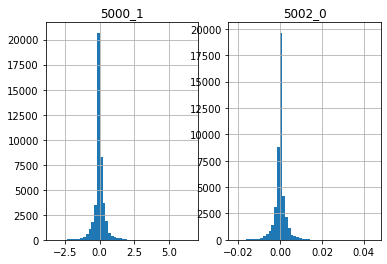

-----------------------------------------
['5000-1', '5002-1']


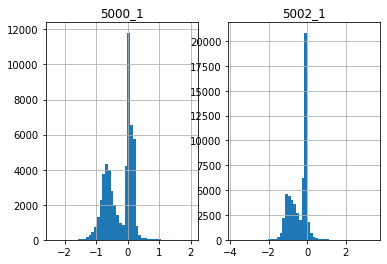

6223.296525433149
Extrinsics Before:
[[-0.04212071 -0.99894382  0.0183602  -0.11878459]
 [ 0.4826647  -0.00425491  0.87579488 -0.77262447]
 [-0.87479176  0.04575093  0.48233414  0.62365187]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.04275324  0.48223848 -0.87499612  0.91177637]
 [-0.99887252 -0.00254209  0.04740495 -0.1497466 ]
 [ 0.02063617  0.87603629  0.48180345  0.38238921]
 [ 0.          0.          0.          1.        ]]


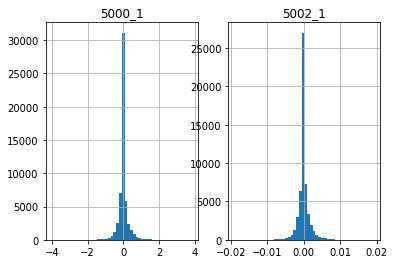

-----------------------------------------
['5001-0', '5001-1']


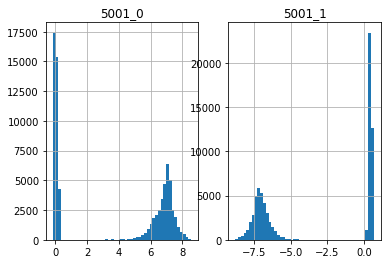

296133.3452762303
Extrinsics Before:
[[ 0.98745223  0.07646181 -0.13817267  0.99663251]
 [-0.06993888  0.99622259  0.05146949  0.00154968]
 [ 0.14158618 -0.04116002  0.98906987  0.08198319]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.98827814 -0.06689403  0.13722797 -0.99671415]
 [ 0.07013343  0.9973585  -0.01890289 -0.06391683]
 [-0.13560099  0.02830558  0.99035911  0.04869824]
 [ 0.          0.          0.          1.        ]]


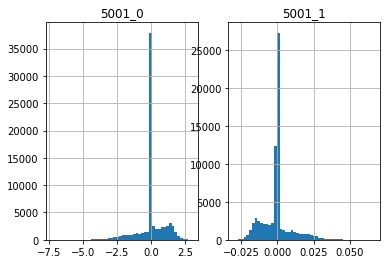

-----------------------------------------
['5001-0', '5002-0']


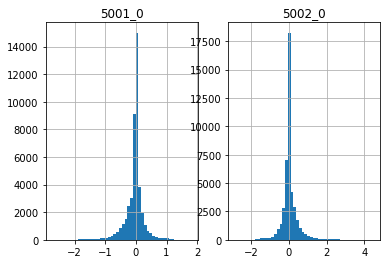

106.62192051586223
Extrinsics Before:
[[-0.04827408  0.99752653 -0.05109237  0.10795734]
 [-0.5145956   0.0190029   0.85722241 -0.75428289]
 [ 0.856073    0.06767353  0.51240541  0.64761295]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.04671052 -0.51523237  0.85577668 -0.93665867]
 [ 0.99765164  0.01889967  0.06583324 -0.13559073]
 [-0.05009331  0.85684211  0.51313961  0.32291593]
 [ 0.          0.          0.          1.        ]]


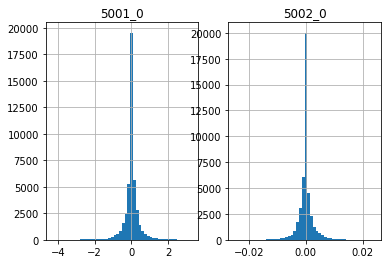

-----------------------------------------
['5001-0', '5002-1']


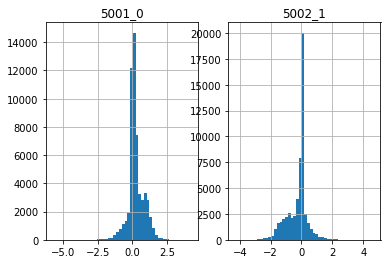

5369.233563249969
Extrinsics Before:
[[-0.05796267  0.99734367 -0.0441127   0.08961858]
 [-0.53389553  0.00636937  0.84552646 -0.73460172]
 [ 0.84356143  0.07256054  0.53210814  0.67255395]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[-0.05726213 -0.53357024  0.84381506 -0.95272831]
 [ 0.99742967  0.00588834  0.07140995 -0.13066203]
 [-0.04307089  0.84573526  0.53186161  0.27418892]
 [ 0.          0.          0.          1.        ]]


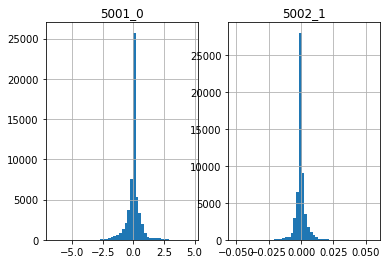

-----------------------------------------
['5001-1', '5002-0']


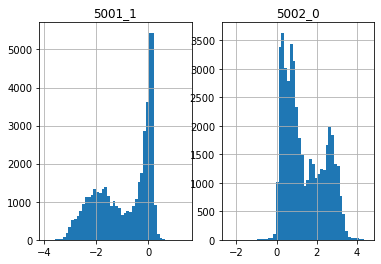

43566.063957085506
Extrinsics Before:
[[ 0.10155467  0.99363334 -0.04877949 -0.09277577]
 [-0.54565897  0.09663433  0.83241702 -0.78614763]
 [ 0.83183108 -0.05791888  0.55199861  0.61103565]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.1017692  -0.54336604  0.83330449 -0.92978173]
 [ 0.99398933  0.08951764 -0.06302217  0.20150216]
 [-0.04035135  0.8347095   0.54921018  0.30798843]
 [ 0.          0.          0.          1.        ]]


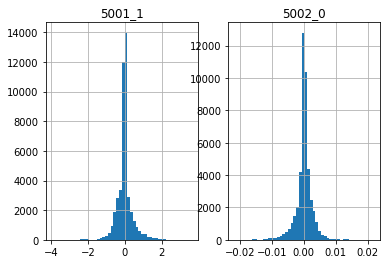

-----------------------------------------
['5001-1', '5002-1']


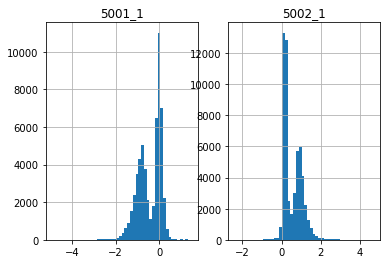

8007.137834101255
Extrinsics Before:
[[ 0.09118476  0.99535023 -0.0310363  -0.07153854]
 [-0.55583482  0.07673056  0.82774396 -0.76118959]
 [ 0.82627658 -0.05822658  0.56024698  0.64457167]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.090956   -0.55535247  0.82662605 -0.94892387]
 [ 0.99542833  0.07499425 -0.05914638  0.16511602]
 [-0.02914511  0.82822671  0.55963477  0.26883992]
 [ 0.          0.          0.          1.        ]]


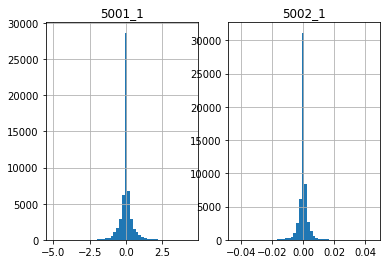

-----------------------------------------
['5002-0', '5002-1']


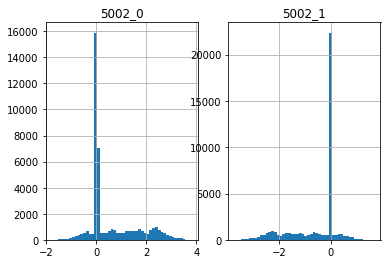

12333.921682269529
Extrinsics Before:
[[ 0.99965741  0.01135621  0.02358196  0.99993094]
 [-0.01162337  0.99986946  0.01122297 -0.01167081]
 [-0.02345143 -0.01149323  0.99965891 -0.00137827]
 [ 0.          0.          0.          1.        ]]
Extrinsics After:
[[ 0.99963531 -0.01156776 -0.02440132 -0.99459694]
 [ 0.01136306  0.99989922 -0.00851099  0.00197529]
 [ 0.02449731  0.00823062  0.99966601  0.06114933]
 [ 0.          0.          0.          1.        ]]


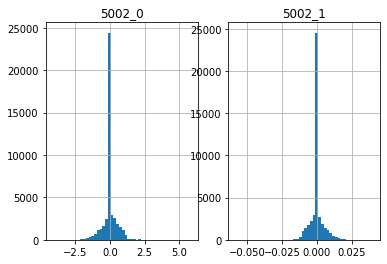

-----------------------------------------


In [50]:
ba_root = 'sample_dataset/pair_extrinsics/ba'
root = 'sample_dataset/pair_extrinsics/geometrical'
plots_root = 'sample_dataset/plots/stereo_pairs/BA/'
gm_ext = StereoGeometricalCalibrator(cam_data_manager=cam_dm)
for pair in pairs:
    print(pair)
    # Load the geometrical extrinsics computed in the previous section
    c1, c2 = pair
    with open(os.path.join(root, f'ext_{c1}->{c2}.pckl'),'rb') as f:
        geom_ext = pickle.load(f)
    
    P1, P2 = geom_ext['P1'], geom_ext['P2']
    K1, K2 = geom_ext['K1'], geom_ext['K2']
    R,t = geom_ext['R|T']
    
    # Load the camera intrinsics 
    K1 = cam_dm.camModels[c1].P[0:3,0:3]
    K2 = cam_dm.camModels[c2].P[0:3,0:3]
    
    # Get the synchronized and raw pixel data of c1-c2 pair
    x1, x2 = cam_dm.getCovisibleMarkerPairs(c1, c2, undist = False, normalized = False)
    # Remove frames where markers are not visible in the pair
    idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
    idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
    idx = np.where(idx1*idx2)

    x1 = x1[idx,...].squeeze()
    x2 = x2[idx,...].squeeze()
    # Make an stereo camera object to reconstruct the 3D positions of the landmarks
    c1 = c1.replace('-','_')
    c2 = c2.replace('-','_')
    cam1_yaml = f'sample_dataset/intrinsics/{c1}.yaml'
    cam2_yaml = f'sample_dataset/intrinsics/{c2}.yaml'

    stereoCamera = StereoCamera(cam1_yaml, 
                                cam2_yaml, P1, P2)
    # Undistrot the raw pixel locations
    x1_undist, x2_undist = stereoCamera.undist(x1, x2)
    # Triangulate the 3D positions of the landmarks
    landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
    # Plot and save the error distribution before BA
    xi_reproj = (P1 @ landmarks.T).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (P2 @ landmarks.T).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]

    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
        
        
    
    plt.savefig(os.path.join(plots_root, f'{c1}->{c2}_before_ba.png'))
    plt.show()
    # Rund the bundle adjustment to improve the quality of calibration
    stereo_ba = StereoBundleAdjustment(R, t, K1, K2)
    stereo_ba.run(x1_undist[:,0:2], x2_undist[:,0:2], landmarks)
    # Compute the reprojection error after BA
    landmarks_opt = np.hstack([stereo_ba.L, np.ones((stereo_ba.L.shape[0],1))]).T
    Pi, Pj = stereo_ba.P1, stereo_ba.P2
    xi_reproj = (Pi @ landmarks_opt).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (Pj @ landmarks_opt).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]

    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    # Plot and save the error distribution after BA
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
        
        
    plt.savefig(os.path.join(plots_root, f'{c1}->{c2}_after_ba.png'))
    plt.show()
    # Save the extrinsics after BA
    params={
        'K1':K1,
        'K2':K2,
        'P1':Pi,
        'P2':Pj,
        'R|T':(stereo_ba.Rj,stereo_ba.tj),
    }
#     assert False
    with open(os.path.join(ba_root, f'ext_{c1}->{c2}.pckl'),'wb') as f:
        pickle.dump(params, f)
    print('-----------------------------------------')


## Compute Relative Scales

### Reconstruct the Point Clouds
Using the final extrinsic paramters, triangulate the 3D position of the landmars as seen by each pair of cameras in the system. 

In [134]:
# All stereo pairs in the system
root = 'sample_dataset/pair_extrinsics/ba/'
params = os.listdir(root)
ext_params = {}
for param in params:
    with open(os.path.join(root, param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
pprint([key for key in ext_params.keys()])

['5000_1->5001_0',
 '5001_1->5002_1',
 '5000_0->5002_0',
 '5000_0->5001_1',
 '5000_0->5001_0',
 '5000_1->5002_1',
 '5001_1->5002_0',
 '5000_0->5002_1',
 '5001_0->5001_1',
 '5002_0->5002_1',
 '5001_0->5002_0',
 '5000_1->5001_1',
 '5001_0->5002_1',
 '5000_1->5002_0',
 '5000_0->5000_1']


In [18]:
# Take the 5002-0 as the reference camera against which all other cameras are synchronized
sync_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=False)
sync_pixels.keys()
sync_pixels['5002-1'].shape

(48237, 2)

5000_1->5001_0


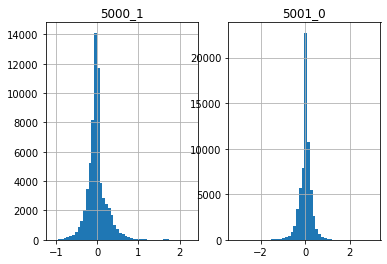

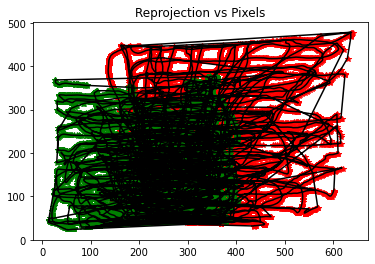

-----------------------------------------
5001_1->5002_1


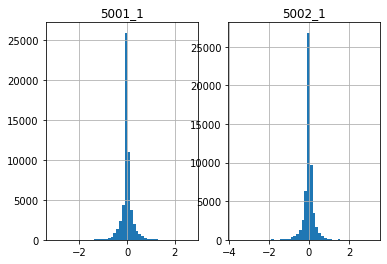

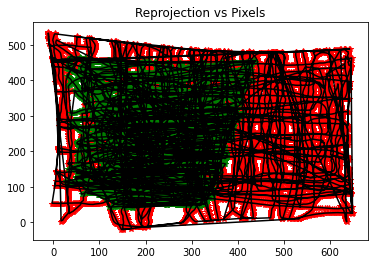

-----------------------------------------
5000_0->5002_0


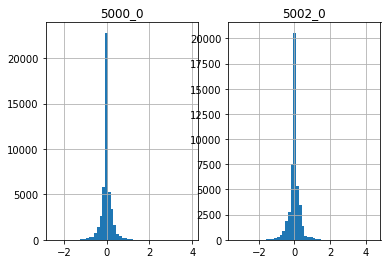

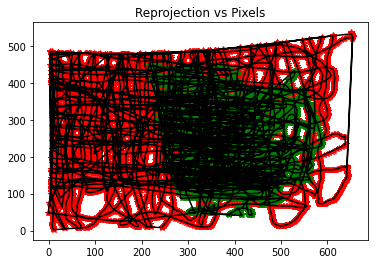

-----------------------------------------
5000_0->5001_1


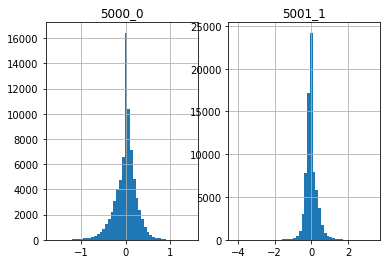

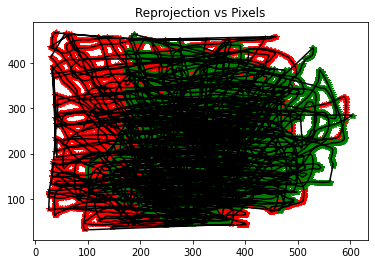

-----------------------------------------
5000_0->5001_0


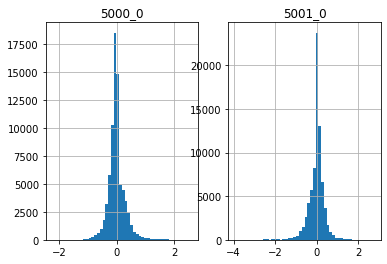

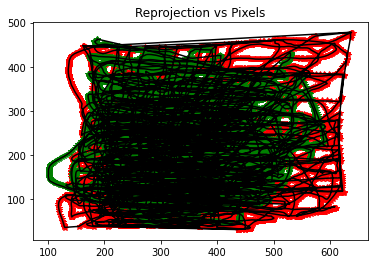

-----------------------------------------
5000_1->5002_1


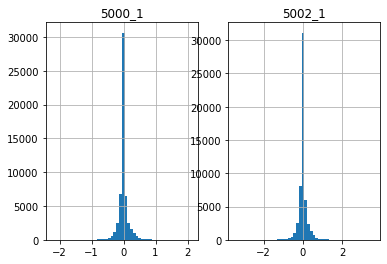

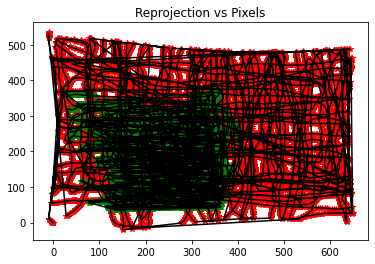

-----------------------------------------
5001_1->5002_0


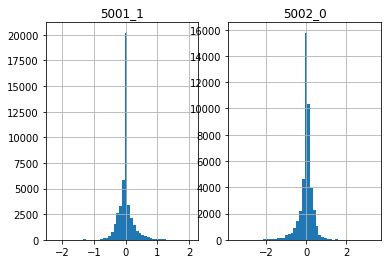

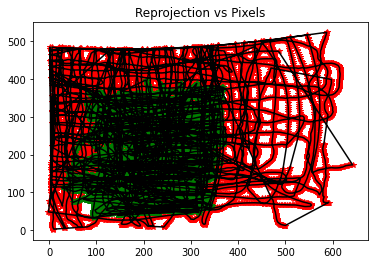

-----------------------------------------
5000_0->5002_1


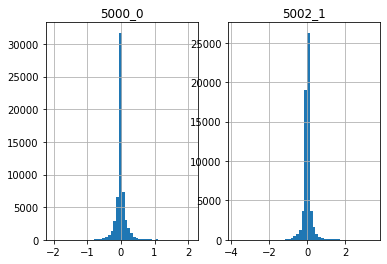

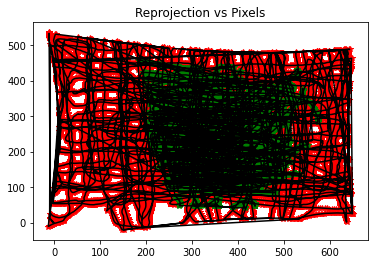

-----------------------------------------
5001_0->5001_1


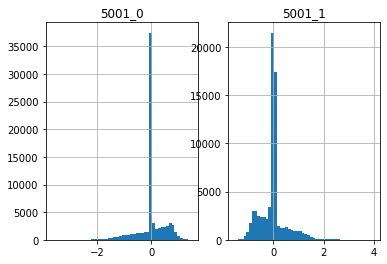

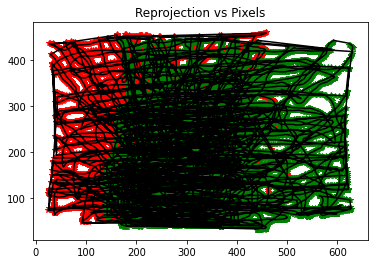

-----------------------------------------
5002_0->5002_1


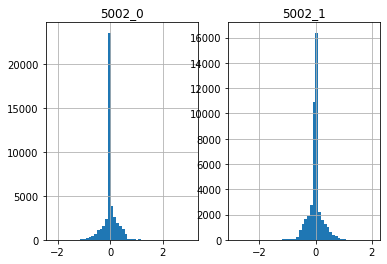

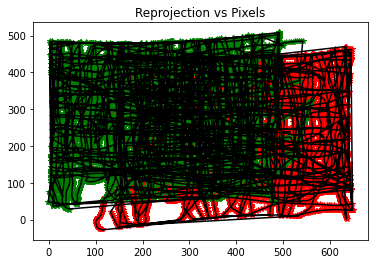

-----------------------------------------
5001_0->5002_0


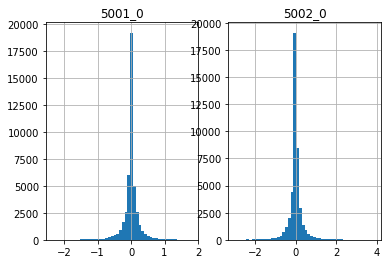

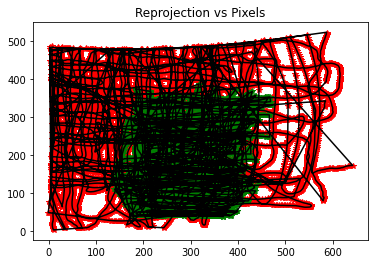

-----------------------------------------
5000_1->5001_1


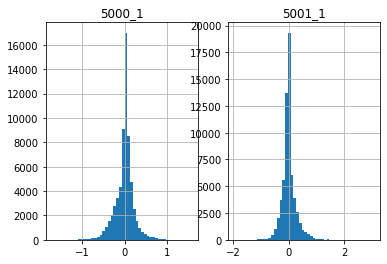

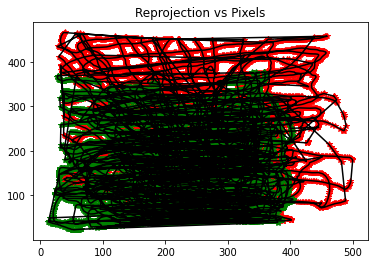

-----------------------------------------
5001_0->5002_1


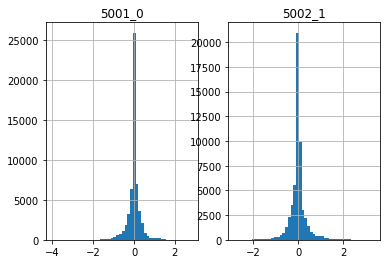

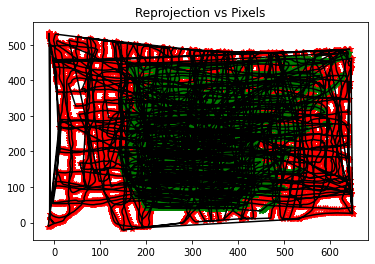

-----------------------------------------
5000_1->5002_0


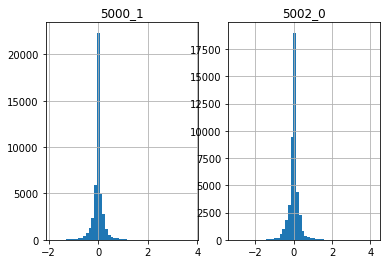

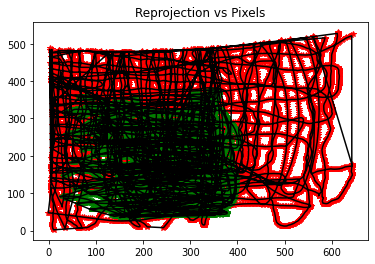

-----------------------------------------
5000_0->5000_1


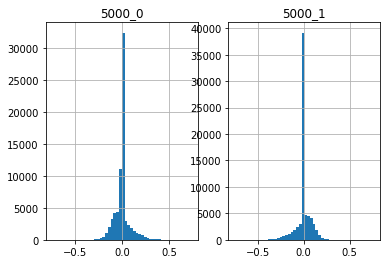

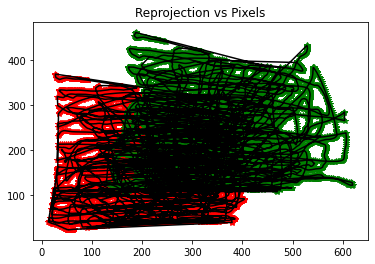

-----------------------------------------


In [138]:
results = {}
root = 'sample_dataset/pair_extrinsics/ba/'
gm_ext = StereoGeometricalCalibrator(cam_data_manager=cam_dm)
for pair in ext_params.keys():
    print(pair)
    # Load the geometrical extrinsics computed in the previous section
    c1, c2 = pair.split('->')
    # Load the camera intrinsics 
    c1 = c1.replace('_','-')
    c2 = c2.replace('_','-')
#     K1 = cam_dm.camModels[c1].P[0:3,0:3]
#     K2 = cam_dm.camModels[c2].P[0:3,0:3]
    
    # Get the synchronized and raw pixel data of c1-c2 pair
    x1, x2 = sync_pixels[c1], sync_pixels[c2]
    result = -np.ones((x1.shape[0],3))
    reprojection_error = np.ones((x1.shape[0]))

    idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
    idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
    idx = np.where(idx1*idx2)

    x1 = x1[idx,...].squeeze()
    x2 = x2[idx,...].squeeze()
    
    c1 = c1.replace('-','_')
    c2 = c2.replace('-','_')
    with open(os.path.join(root, f'ext_{c1}->{c2}.pckl'),'rb') as f:
        geom_ext = pickle.load(f)
    
    P1, P2 = geom_ext['P1'], geom_ext['P2']
    R,t = geom_ext['R|T']
   
    # Make an stereo camera object to reconstruct the 3D positions of the landmarks
    cam1_yaml = f'sample_dataset/intrinsics/{c1}.yaml'
    cam2_yaml = f'sample_dataset/intrinsics/{c2}.yaml'

    stereoCamera = StereoCamera(cam1_yaml, 
                                cam2_yaml, P1, P2)
    # Undistrot the raw pixel locations
    x1_undist, x2_undist = stereoCamera.undist(x1, x2)
    
    # Triangulate the 3D positions of the landmarks
    landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
    result[idx,...]=landmarks.squeeze()[:,0:3]
    
    # Plot and save the error distribution before BA
    xi_reproj = (P1 @ landmarks.T).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (P2 @ landmarks.T).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]
    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    
    reprojection_error[idx,...] = (np.linalg.norm(xj_reproj - x2_undist[:,0:2], axis = -1)+
                          np.linalg.norm(xi_reproj - x1_undist[:,0:2], axis = -1))/2

    # Plot the reprojection error distribution
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
    plt.show()
    
    # Plot the reprojections of the landmarks on the image
    plt.figure()
    plt.title('Reprojection vs Pixels')
    plt.plot(xj_reproj[:,0],xj_reproj[:,1],'r*')
    plt.plot(xi_reproj[:,0],xi_reproj[:,1],'g*')
    plt.plot(x1_undist[:,0],x1_undist[:,1],'k')
    plt.plot(x2_undist[:,0],x2_undist[:,1],'k')
    plt.show()
    c1 = c1.replace('_','-')
    c2 = c2.replace('_','-')
    results[f'{c1}->{c2}']={'landmarks':result, 'error':reprojection_error.reshape(-1,1)}
    print('-----------------------------------------')


In [139]:
from pprint import pprint
pprint([f'pair {key}: {[k for k in results[key].keys()]}' for key in results.keys()])

["pair 5000-1->5001-0: ['landmarks', 'error']",
 "pair 5001-1->5002-1: ['landmarks', 'error']",
 "pair 5000-0->5002-0: ['landmarks', 'error']",
 "pair 5000-0->5001-1: ['landmarks', 'error']",
 "pair 5000-0->5001-0: ['landmarks', 'error']",
 "pair 5000-1->5002-1: ['landmarks', 'error']",
 "pair 5001-1->5002-0: ['landmarks', 'error']",
 "pair 5000-0->5002-1: ['landmarks', 'error']",
 "pair 5001-0->5001-1: ['landmarks', 'error']",
 "pair 5002-0->5002-1: ['landmarks', 'error']",
 "pair 5001-0->5002-0: ['landmarks', 'error']",
 "pair 5000-1->5001-1: ['landmarks', 'error']",
 "pair 5001-0->5002-1: ['landmarks', 'error']",
 "pair 5000-1->5002-0: ['landmarks', 'error']",
 "pair 5000-0->5000-1: ['landmarks', 'error']"]


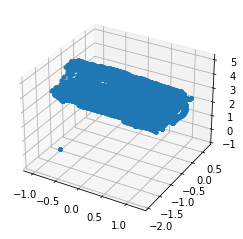

In [22]:
#Plot one of the reconstructions for sanity check
# %matplotlib
pair = '5000-0->5000-1'
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(results[pair]['landmarks'][:,0],
          results[pair]['landmarks'][:,1],
          results[pair]['landmarks'][:,2], '.')
plt.show()

Each camera has its own view of the scene. This view of the scene is common between all stereo pairs made from this camera and the other cameras. In this section, we use this fact to find a set of scales that after multiplication by the reconstructions put them into a unified local scale.

In [23]:
#All subsets of stereo pairs corresponding to a reference view
cam_keys = [key for key in cam_dm.pixel_locations.keys()]

ref_views = {}
n_camera = 6
for i in range(n_camera-1):
    pairs = []
    for j in range(i,n_camera):
        if i != j:
            pairs.append(f'{cam_keys[i]}->{cam_keys[j]}')
    ref_views[cam_keys[i]] = pairs

pprint(ref_views)

{'5000-0': ['5000-0->5000-1',
            '5000-0->5001-0',
            '5000-0->5001-1',
            '5000-0->5002-0',
            '5000-0->5002-1'],
 '5000-1': ['5000-1->5001-0',
            '5000-1->5001-1',
            '5000-1->5002-0',
            '5000-1->5002-1'],
 '5001-0': ['5001-0->5001-1', '5001-0->5002-0', '5001-0->5002-1'],
 '5001-1': ['5001-1->5002-0', '5001-1->5002-1'],
 '5002-0': ['5002-0->5002-1']}


Where in the above:

${ref}_i:\{(cam_i-cam_j) | j \neq i\}$

In [144]:
def computeRelativeScales(results, ref_views):
    '''Get the reconstruction results and compute the relative scales of the pointclouds for each reference view'''
    relative_scales = {}
    for view in ref_views.keys():
        scales = {}
        #Create a list of the reconstructions for each pari in each view [num_pairs_per_view x N x 3]
        landmarks_per_view = np.vstack([results[pair]['landmarks'].reshape(1,-1,3) for pair in ref_views[view]])
        # indices of frames of each stereo pair with visible markers [N x num_pairs_per_view]
        visible_idx = np.hstack([np.all(landmarks_per_view[i,...]!=np.array([-1,-1, -1]), axis=-1).reshape(-1,1) 
                      for i in range(landmarks_per_view.shape[0])])

        scales = {f'{ref_views[view][0]}__{ref_views[view][0]}':1}
        for i in range(1, landmarks_per_view.shape[0]):
            #indecices of frame where both reference pair (0) and sub pairs (i) see the marker
            idx = np.all(visible_idx[:,np.array([0,i])], axis=-1)
#             print(landmarks_per_view.shape)
            ref_pair_scale = np.linalg.norm(landmarks_per_view[0,idx, ...], axis = -1)
            sub_pair_scale = np.linalg.norm(landmarks_per_view[i,idx, ...], axis = -1)
            non_zero_idx = np.where(sub_pair_scale>0.1)
            s = ref_pair_scale[non_zero_idx]/sub_pair_scale[non_zero_idx]
            scales[f'{ref_views[view][0]}__{ref_views[view][i]}'] = s.mean()
        
        relative_scales[view] = scales
    return relative_scales
        
relative_scales = computeRelativeScales(results, ref_views)
pprint(relative_scales)

{'5000-0': {'5000-0->5000-1__5000-0->5000-1': 1,
            '5000-0->5000-1__5000-0->5001-0': 0.9999670683697375,
            '5000-0->5000-1__5000-0->5001-1': 0.9999715187001426,
            '5000-0->5000-1__5000-0->5002-0': 0.9999969281375329,
            '5000-0->5000-1__5000-0->5002-1': 0.9999822855989875},
 '5000-1': {'5000-1->5001-0__5000-1->5001-0': 1,
            '5000-1->5001-0__5000-1->5001-1': 0.9999985134854334,
            '5000-1->5001-0__5000-1->5002-0': 0.9999944761363327,
            '5000-1->5001-0__5000-1->5002-1': 0.9999970762247845},
 '5001-0': {'5001-0->5001-1__5001-0->5001-1': 1,
            '5001-0->5001-1__5001-0->5002-0': 1.0002460569117135,
            '5001-0->5001-1__5001-0->5002-1': 1.0002284905123566},
 '5001-1': {'5001-1->5002-0__5001-1->5002-0': 1,
            '5001-1->5002-0__5001-1->5002-1': 1.0000276157837944},
 '5002-0': {'5002-0->5002-1__5002-0->5002-1': 1}}


In [25]:
# save the computed scales
with open('sample_dataset/pair_extrinsics/relative_scales.pckl', 'wb') as f:
    pickle.dump(relative_scales,f)

## Generate Fused Point Clouds per View
In this section, we make unified point clouds that correspond to each camera. To do so, we weight the points with lower reprojection error higher than those with bigger errors.

In [145]:
# pprint(relative_scales)
pc_per_view = {}
for view in relative_scales:
    
    pcs = []
    for pc_pair in relative_scales[view]:
        pc1, pc2 = pc_pair.split('__')

        #The relative scale between pc1 and pc2. Note that for each view, pc1 is identical.
        s = relative_scales[view][pc_pair]
        pc = results[pc2]['landmarks'].copy()
        
        #Where are markers visible? (Not equal [-1, -1, -1])
        idx =      np.where(np.all(pc!=-1, axis = -1))[0]
        idx_null = np.where(np.all(pc==-1, axis = -1))[0]
        #Scale the point cloud
        pc[idx,...] = pc[idx,...]*s
        pc[idx_null,...] = [0, 0, 0]
        pcs.append(pc)
        
    scaled_pcs = np.stack(pcs)
    #How many nonzero samples we have in in the avaraging process
    avg_den = np.count_nonzero(np.all(scaled_pcs!=0, axis = -1), axis = 0).reshape(-1,1)
    #Compute the average and divide by the number of non-zero samples
    avg = np.sum(scaled_pcs, axis = 0)
    #Note, we should not divide by zero
    avg[np.where(avg_den!=0)[0]] /= avg_den[np.where(avg_den!=0)[0]]
    #save the unified point cloud
    avg[np.where(avg_den==0)[0],...]=[-1,-1,-1]
    pc_per_view[view]=avg

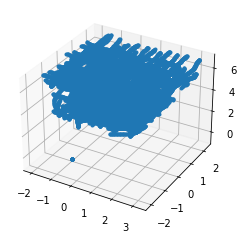

In [146]:
#Plot one of the reconstructions for sanity check
# %matplotlib
view = '5002-0'
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(pc_per_view[view][:,0],
          pc_per_view[view][:,1],
          pc_per_view[view][:,2], '.')
plt.show()

## Align the Pointclouds From All Views
At this point, we have unified pointclouds per each view. Here, we use the Umeyama algorithm to find the SIM(3) transformations between each of these point clouds.  

### A Simple Test For One View

First, let's do a simple test and align just two of the point clouds

In [147]:
import sys
from src.rpg_trajectory_evaluation.align_trajectory import *

P1 = pc_per_view['5002-0']
P2 = pc_per_view['5001-0']

a_with_marker = np.sum(P1,axis=-1)!= -3
b_with_marker = np.sum(P2,axis=-1)!= -3
a_b_with_marker = np.logical_and(a_with_marker, b_with_marker)
idx = np.where(a_b_with_marker)

A = P1[a_b_with_marker,:]
B = P2[a_b_with_marker,:]

In [149]:
s, R, t = align_umeyama(A,B)
B_prime =( s * R @ B.T + t.reshape(3,1)).T

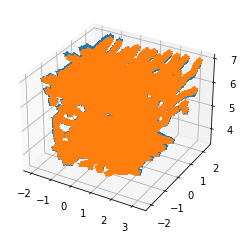

In [150]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(A[:,0],A[:,1],A[:,2],'*')
ax.plot3D(B_prime[:,0],B_prime[:,1],B_prime[:,2],'*')
plt.show()

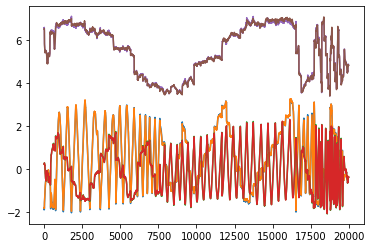

In [151]:
plt.plot(A[:,0])
plt.plot(B_prime[:,0])

plt.plot(A[:,1])
plt.plot(B_prime[:,1])

plt.plot(A[:,2])
plt.plot(B_prime[:,2])

### Compute the Transformations for all Views

Now we take one of the cameras as the reference view and compute the alignment parameters to align all other views to this single reference view.

0.9999778490189386
0.9999532787870651
0.9996683510048341
0.9999093235925198
1.0000000000000004


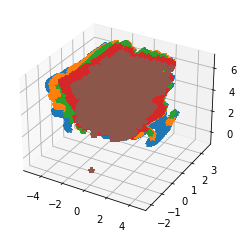

In [152]:
# %matplotlib
ref_cam = '5002-0'
P1 = pc_per_view[ref_cam][:,:]
alignment_params = {}

# other_views = ['5000-0', '5000-1', '5001-0', '5001-1', '5002-0', '5002-1', '5003-0']
other_views = ['5000-0', '5000-1', '5001-0', '5001-1', '5002-0']
# other_views = ['5000-0']

plt.figure()
ax = plt.axes(projection='3d')
reconstructions_aligned = [P1]

for view in other_views:
    P2 = pc_per_view[view]
    invisible_idx = np.where(P2==[-1,-1,-1])[0]
    a_with_marker = np.sum(P1,axis=-1)!=-3
    b_with_marker = np.sum(P2,axis=-1)!=-3
    a_b_with_marker = np.logical_and(a_with_marker, b_with_marker)
    idx = np.where(a_b_with_marker)
    
    A = P1[a_b_with_marker,:]
    B = P2[a_b_with_marker,:]

    s, R, t = align_umeyama(A,B)

    alignment_params[f'{ref_cam}_{view}'] = {'s':s, 'R':R, 't':t}
    P2_prime =( s * R @ P2.T + t.reshape(3,1)).T
    P2_prime[invisible_idx,:] = -np.ones((1,3))
    reconstructions_aligned.append(P2_prime)
    ax.plot3D(P2_prime[:,0],P2_prime[:,1],P2_prime[:,2],'*')
    
ax.plot3D(P1[:,0],P1[:,1],P1[:,2],'*')

with open('sample_dataset/alignment_params.pckl', 'wb') as f:
    pickle.dump(alignment_params,f)

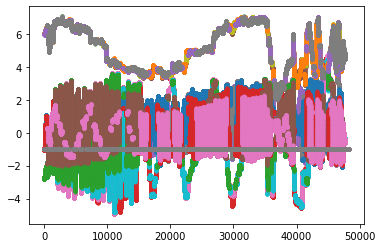

In [38]:
for path in reconstructions_aligned:
    plt.plot(path,'.')

In [35]:
pprint(alignment_params)

{'5002-0_5000-0': {'R': array([[ 0.06531295,  0.50060306, -0.86320959],
       [-0.99580072,  0.0883096 , -0.0241316 ],
       [ 0.06414934,  0.86116084,  0.50426865]]),
                   's': 2.3851680105733934,
                   't': array([7.6530475 , 1.18150967, 2.37617578])},
 '5002-0_5000-1': {'R': array([[-5.20960107e-02,  5.22057445e-01, -8.51317820e-01],
       [-9.98140882e-01, -2.15541486e-04,  6.09486045e-02],
       [ 3.16351784e-02,  8.52910299e-01,  5.21098107e-01]]),
                   's': 14.180991814738952,
                   't': array([ 7.65088   , -1.16181073,  2.46845975])},
 '5002-0_5001-0': {'R': array([[-0.04674587, -0.50400443,  0.86243513],
       [ 0.99759072,  0.02075041,  0.06619807],
       [-0.05126001,  0.86345177,  0.50182015]]),
                   's': 2.3711980177704954,
                   't': array([-6.52992702, -0.94139756,  2.38527253])},
 '5002-0_5001-1': {'R': array([[ 0.10012821, -0.52522926,  0.84504945],
       [ 0.99390635,  0.09214399, 

In [39]:
def unifyScales(relative_scales, alignment_params):
    '''Use the alignment scales computed by pointcloud registeration and scale the relative_scales to get a unifed scale for all pairs'''
    ref_cam = [k for k in alignment_params][0].split('_')[0]
    combined_scale = {}
    pairs = {}
    for key in alignment_params:
        target_view = key.split('_')[1]
        #Get the alignement scale
        s = alignment_params[key]['s']
        combined_scale.update({k:(v)*(s) for k,v in zip(relative_scales[target_view].keys(),
                                                            relative_scales[target_view].values())})
        
        ref_pair = [k for k in relative_scales[target_view]][0].split('__')[0]
        pairs[ref_pair] = s
#   Change the key names to a shorter version
    for key in combined_scale.keys():
#         ref_pair = key.split('_')[0]
        target_pair = key.split('_')[-1]
        pairs.update({target_pair:combined_scale[key]})
        
    return pairs
pair_scales = unifyScales(relative_scales, alignment_params)
with open('sample_dataset/unified_pair_scales.pckl', 'wb') as f:
    pickle.dump(pair_scales,f)

In [40]:
pair_scales

{'5000-0->5000-1': 2.3851680105733934,
 '5000-1->5001-0': 14.180991814738952,
 '5001-0->5001-1': 2.3711980177704954,
 '5001-1->5002-0': 6.8231686397888245,
 '5002-0->5002-1': 1.0000000000000007,
 '5000-0->5001-0': 14.333339902400136,
 '5000-0->5001-1': 14.073620368629138,
 '5000-0->5002-0': 8.180636508185728,
 '5000-0->5002-1': 7.252911866865348,
 '5000-1->5001-1': 14.309662419951096,
 '5000-1->5002-0': 8.205987870301001,
 '5000-1->5002-1': 7.333359778390047,
 '5001-0->5002-0': 6.924441849491478,
 '5001-0->5002-1': 7.905094422465437,
 '5001-1->5002-1': 7.827632878755763}

### Compute the Final Extrinsics

Use the estimated scales and extrinsics to compute a new set of stereo extrinsic pairs that produce triangulations represented in the reference view. 

In [126]:
params = os.listdir('sample_dataset/pair_extrinsics/ba/')
stereo_exts = {}
for param in params:
    with open(os.path.join('sample_dataset/pair_extrinsics/ba/', param), 'rb') as f:
        stereo_exts[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)

#### Compute New Extrinsics with Corrected Scale

In [137]:
for pair in stereo_exts.keys():
    c1, c2 = pair.replace('_','-').split('->')
    s = pair_scales[pair.replace('_','-')]
    
    R_c1_c2, t_c1_c2 = stereo_exts[pair]['R|T']
    t_c1_c2 = t_c1_c2*s#Scale the pair baseline
    T_c1_c2 = np.vstack([np.hstack([R_c1_c2, t_c1_c2]),
                              np.array([0,0,0,1]).reshape(1,4)])
    
    P1 = stereo_exts[pair]['K1']@np.hstack([np.eye(3), np.zeros((3,1))])
    P2 = stereo_exts[pair]['K2']@np.hstack([R_c1_c2, t_c1_c2])
    
    stereo_exts[pair]['P1'] = P1
    stereo_exts[pair]['P2'] = P2

In [128]:
pprint(stereo_exts['5000_0->5000_1'])

{'K1': array([[521.7262 ,   0.     , 302.95849],
       [  0.     , 533.24994, 323.97897],
       [  0.     ,   0.     ,   1.     ]]),
 'K2': array([[539.95917,   0.     , 297.24435],
       [  0.     , 535.68652, 262.91178],
       [  0.     ,   0.     ,   1.     ]]),
 'P1': array([[521.7262 ,   0.     , 302.95849,   0.     ],
       [  0.     , 533.24994, 323.97897,   0.     ],
       [  0.     ,   0.     ,   1.     ,   0.     ]]),
 'P2': array([[ 5.09689012e+02, -3.89001412e+01,  3.44403831e+02,
        -1.25425706e+03],
       [ 2.50990846e+01,  5.40854997e+02,  2.50855657e+02,
        -1.60795319e+01],
       [-8.75010284e-02,  2.83171593e-02,  9.95761873e-01,
         1.05325397e-01]]),
 'R|T': (array([[ 0.99210871, -0.08763118,  0.08967204],
       [ 0.08979904,  0.99575043, -0.02042588],
       [-0.08750103,  0.02831716,  0.99576187]]),
         array([[-0.9981917 ],
       [-0.03425745],
       [ 0.04415848]]))}


# Reconstruct Points
Use the estimated scale and geometrical paramters to reconstruct the point clouds. This point cloud will be used to initilize the pose graph in the next section

In [129]:
# Take the 5002-0 as the reference camera against which all other cameras are synchronized
sync_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=False)
sync_pixels.keys()
sync_pixels['5002-1'].shape

(48237, 2)

5000_1->5001_0


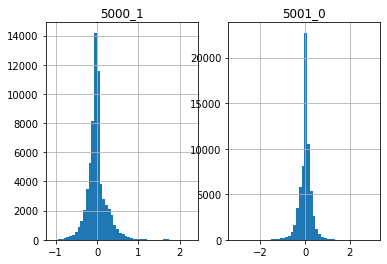

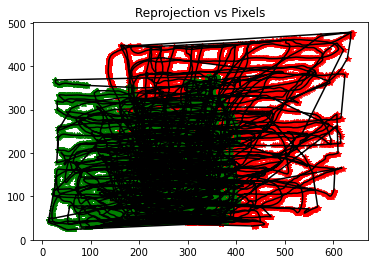

-----------------------------------------
5001_1->5002_1


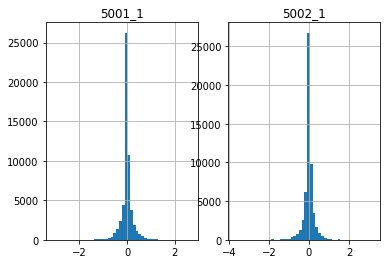

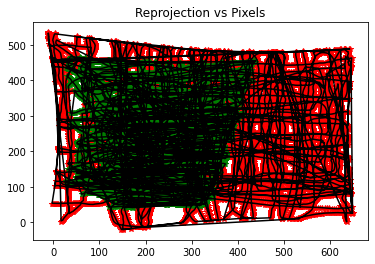

-----------------------------------------
5000_0->5002_0


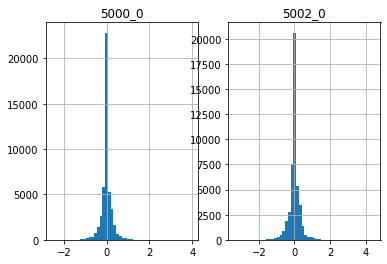

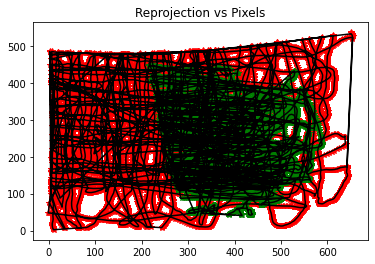

-----------------------------------------
5000_0->5001_1


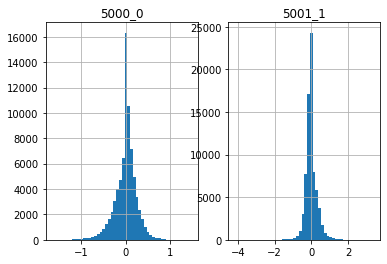

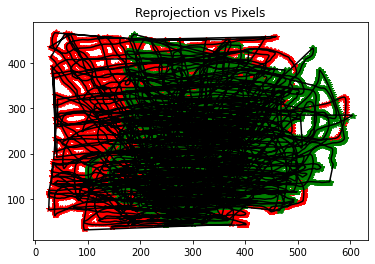

-----------------------------------------
5000_0->5001_0


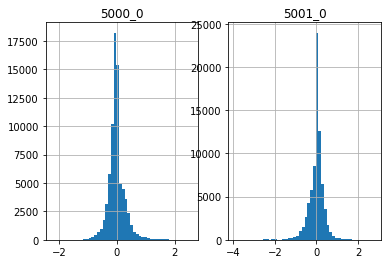

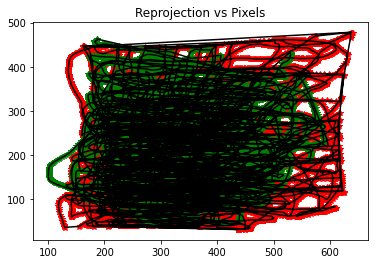

-----------------------------------------
5000_1->5002_1


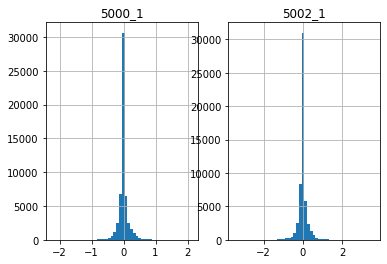

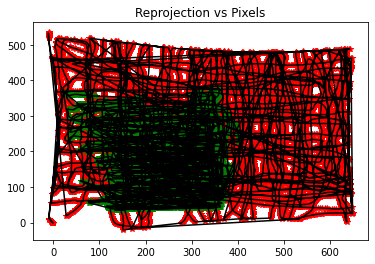

-----------------------------------------
5001_1->5002_0


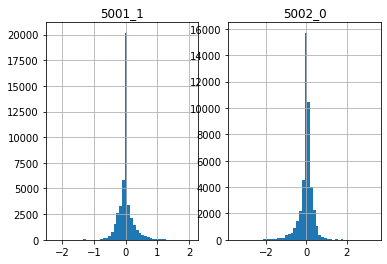

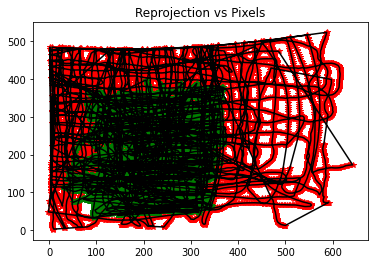

-----------------------------------------
5000_0->5002_1


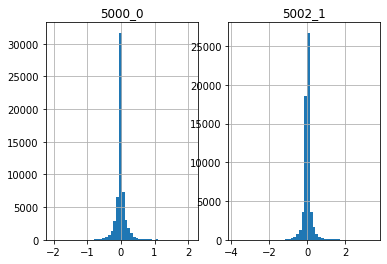

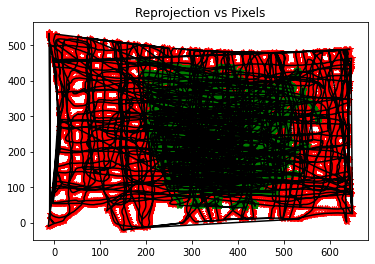

-----------------------------------------
5001_0->5001_1


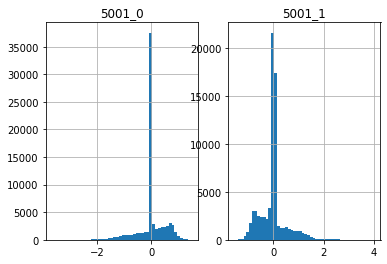

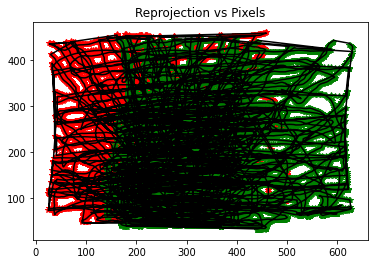

-----------------------------------------
5002_0->5002_1


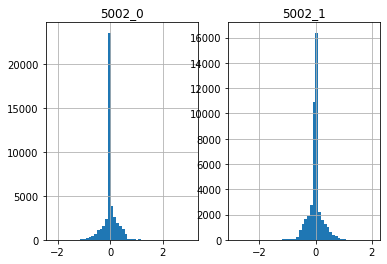

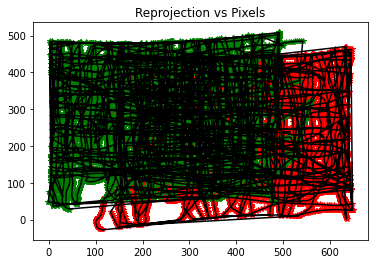

-----------------------------------------
5001_0->5002_0


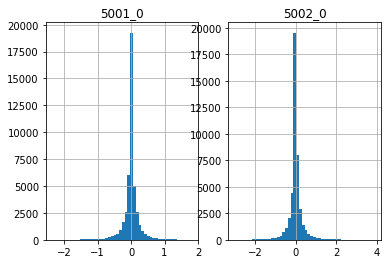

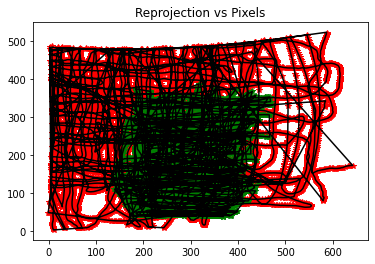

-----------------------------------------
5000_1->5001_1


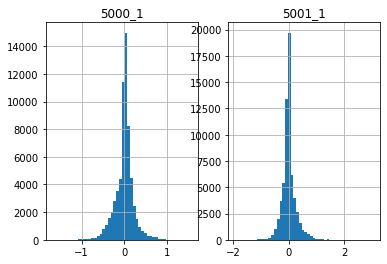

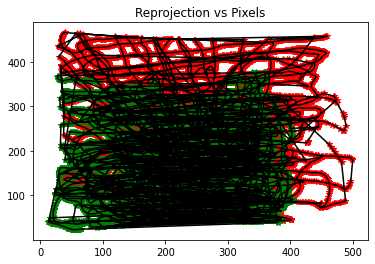

-----------------------------------------
5001_0->5002_1


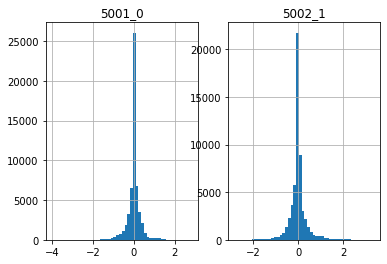

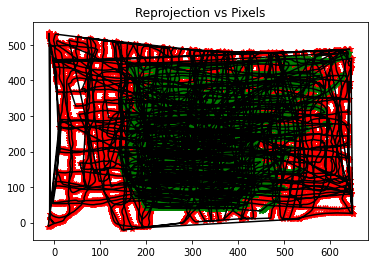

-----------------------------------------
5000_1->5002_0


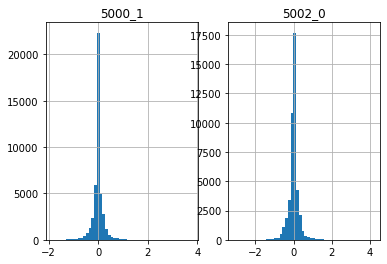

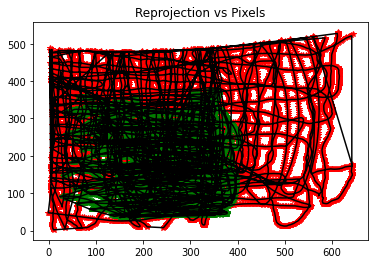

-----------------------------------------
5000_0->5000_1


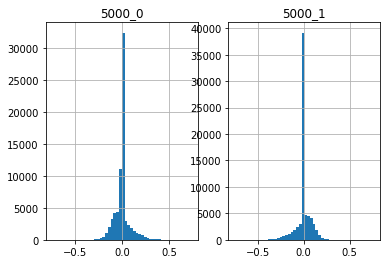

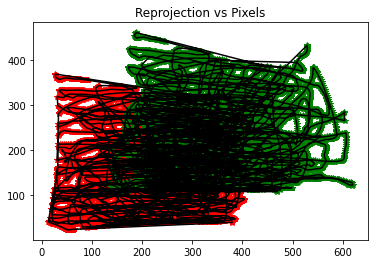

-----------------------------------------


In [141]:
results = {}
for pair in ext_params.keys():
    print(pair)
    # Load the geometrical extrinsics computed in the previous section
    c1, c2 = pair.split('->')
    # Load the camera intrinsics 
    c1 = c1.replace('_','-')
    c2 = c2.replace('_','-')
    
    # Get the synchronized and raw pixel data of c1-c2 pair
    x1, x2 = sync_pixels[c1], sync_pixels[c2]
    result = -np.ones((x1.shape[0],3))
    reprojection_error = np.ones((x1.shape[0]))

    idx1 = np.all(x1!=np.array([-1,-1]), axis=-1)
    idx2 = np.all(x2!=np.array([-1,-1]), axis=-1)
    idx = np.where(idx1*idx2)

    x1 = x1[idx,...].squeeze()
    x2 = x2[idx,...].squeeze()
    
    c1 = c1.replace('-','_')
    c2 = c2.replace('-','_')
#     with open(os.path.join(root, f'ext_{c1}->{c2}.pckl'),'rb') as f:
#         geom_ext = pickle.load(f)
        
    geom_ext = stereo_exts[f'{c1}->{c2}']
    
    P1, P2 = geom_ext['P1'], geom_ext['P2']
   
    # Make a stereo camera object to reconstruct the 3D positions of the landmarks
    cam1_yaml = f'sample_dataset/intrinsics/{c1}.yaml'
    cam2_yaml = f'sample_dataset/intrinsics/{c2}.yaml'

    stereoCamera = StereoCamera(cam1_yaml, 
                                cam2_yaml, P1, P2)
    # Undistrot the raw pixel locations
    x1_undist, x2_undist = stereoCamera.undist(x1, x2)
    
    # Triangulate the 3D positions of the landmarks
    landmarks = stereoCamera.triangulate(x1_undist, x2_undist, undist=False)
    result[idx,...]=landmarks.squeeze()[:,0:3]
    
    # Plot and save the error distribution before BA
    xi_reproj = (P1 @ landmarks.T).T
    xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

    xj_reproj = (P2 @ landmarks.T).T
    xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]
    ej = (xj_reproj - x2_undist[:,0:2]).reshape(-1,1)
    ei = (xi_reproj - x1_undist[:,0:2]).reshape(-1,1)
    
    reprojection_error[idx,...] = (np.linalg.norm(xj_reproj - x2_undist[:,0:2], axis = -1)+
                          np.linalg.norm(xi_reproj - x1_undist[:,0:2], axis = -1))/2

    # Plot the reprojection error distribution
    fig,ax=plt.subplots(1,2)
    _ = ax[0].hist(ei, bins=50)
    _ = ax[0].set_title(c1)
    ax[0].grid(True)

    _ = ax[1].hist(ej, bins=50)
    _ = ax[1].set_title(c2)
    ax[1].grid(True)
    plt.show()
    
    # Plot the reprojections of the landmarks on the image
    plt.figure()
    plt.title('Reprojection vs Pixels')
    plt.plot(xj_reproj[:,0],xj_reproj[:,1],'r*')
    plt.plot(xi_reproj[:,0],xi_reproj[:,1],'g*')
    plt.plot(x1_undist[:,0],x1_undist[:,1],'k')
    plt.plot(x2_undist[:,0],x2_undist[:,1],'k')
    plt.show()
    c1 = c1.replace('_','-')
    c2 = c2.replace('_','-')
    results[f'{c1}->{c2}']={'landmarks':result, 'error':reprojection_error.reshape(-1,1)}
    print('-----------------------------------------')


In [ ]:
from pprint import pprint
with open('ext_params/dataset_v2/alignment_params.pckl', 'rb') as f:
    alignment_params = pickle.load(f)

with open('ext_params/dataset_v2/relative_scales.pckl', 'rb') as f:
    relative_scales = pickle.load(f)
    
params = os.listdir('ext_params/dataset_v2/pairs_without_uncertainty/')
ext_params = {}
for param in params:
    with open(os.path.join('ext_params/dataset_v2/pairs_without_uncertainty/', param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)

In [ ]:
#compute all the possible camera pirs per each camera view
cam_keys = [key for key in cam_dm.pixel_locations.keys()]

frames = {}
n_camera = 6
for i in range(n_camera-1):
    pairs = []
    for j in range(i,n_camera):
        if i != j:
            pairs.append(f'{cam_keys[i]}->{cam_keys[j]}')
    frames[cam_keys[i]] = pairs
# del frames['5000-0']
pprint(frames)

Let's bring the function definitions from the previous section for the sake of convenience.

In [ ]:
def triangulatePairs(xi, xj, Pi, Pj):
    both_visible = np.all((xi.squeeze()!=[-1,-1]), axis = -1) * np.all((xj.squeeze()!=[-1,-1]), axis = -1)
    both_not_visible = np.where(~both_visible)[0]
    points=cv2.triangulatePoints(Pi,Pj,xi.reshape(-1,1,2),xj.reshape(-1,1,2))
    points[:,both_not_visible] = np.array([-1, -1, -1, 1]).reshape(4,1)
    return (points/points[-1,:]).T

def getReprojectionError(xi, xj, Pi, Pj, point_3d):
    reprojected1 = Pi @ point_3d.reshape(4,-1)
    reprojected1 = reprojected1/reprojected1[-1,:]
    reprojected2 = Pj @ point_3d.reshape(4,-1)
    reprojected2 = reprojected2/reprojected2[-1,:]
    error_i = np.mean(np.linalg.norm(reprojected1[0:2,:].T-xi, axis =-1))
    error_j = np.mean(np.linalg.norm(reprojected2[0:2,:].T-xj, axis =-1))
    return (error_i+error_j)/2

def getNormalizedReprojectionError(xi, xj, Pi, Pj, points_3d):
    both_visible = np.all((xi.squeeze()!=[-1,-1]), axis = -1) * np.all((xj.squeeze()!=[-1,-1]), axis = -1)
    both_visible_idx = np.where(both_visible)[0]
    
    reprojected1=np.dot(Pi,points_3d[both_visible_idx,:].T)
    reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])[:,0:2]
    
    reprojected2=np.dot(Pj,points_3d[both_visible_idx,:].T)
    reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])[:,0:2]
    
    error_i = np.mean(np.abs(reprojected1[:,0:2]-xi[both_visible_idx,:]), axis=-1)
    error_j = np.mean(np.abs(reprojected2[:,0:2]-xj[both_visible_idx,:]), axis=-1)
    return np.mean((error_i+error_j)/2), np.std((error_i+error_j)/2)


def reconstructPoints(frames, ext_params, x):
    results = {}
    for frame in frames.keys():
        landmarks_in_frame = {}
        error_per_landmark_in_frame = {}

        for key in frames[frame]:
            if key in ext_params.keys():
                c1, c2 = key.split('->')
                Pi, Pj = ext_params[key]['P']
                #Are there mutually visible markers in i and j frames?
                visible = np.all((x[c1].squeeze()!=[-1,-1]), axis = -1) * \
                          np.all((x[c1].squeeze()!=[-1,-1]), axis = -1)
                if any(visible):
                    landmark = triangulatePairs(x[c1], x[c2], Pi, Pj)
                    error_per_landmark_in_frame[key] = getNormalizedReprojectionError(x[c1],x[c2], Pi, Pj, landmark)
                    landmarks_in_frame[key] = landmark.squeeze()[:, 0:3]
                else:
                    landmark = -np.ones((x[c1].shape[0],3))
                    error_per_landmark_in_frame[key] = -np.ones((x[c1].shape[0],1))
                    landmarks_in_frame[key] = landmark.squeeze()[:, 0:3]
                    
        results[frame] = {'landmarks':landmarks_in_frame, 'errors':error_per_landmark_in_frame}
    return results


def scaleSubPointClouds(results, relative_scales):
    '''Given the scales and the results, scale and average the recustructed 3D points in each frame of the results'''
    pointcloud_per_view = {}
    for view in results.keys():
        #Generate the list of pairs and relative scale keys
        pairs = [pair_key for pair_key in results[view]['landmarks'].keys()]
        relative_keys = [f'{pairs[0]}__{pairs[i]}' for i in range(1, len(pairs))]

        #Generate masks so that we can only scale those points with visible markers and not the -1 marker loss indicators
        invisible_idx = [np.where(np.all(results[view]['landmarks'][pair] == [-1, -1, -1], axis = -1))[0] for pair in pairs]
        visible_bools = np.vstack([np.all(results[view]['landmarks'][pair] != [-1, -1, -1], axis = -1) for pair in pairs]).T
        #Scale the sub pointclouds for each view and make a tensor of size (n_rows, n_pairs, 3)
        scaled_pointclouds = [results[view]['landmarks'][pair].reshape(-1,1,3) * relative_scales[view][s_key]
                              for pair,s_key in zip(pairs[1:], relative_keys)]  
        scaled_pointclouds.insert(0, results[view]['landmarks'][pairs[0]].reshape(-1,1,3))
        #Reset the -1 ivisible points back to -1
        for i in range(len(scaled_pointclouds)):
            scaled_pointclouds[i][invisible_idx[i],:] = [-1, -1, -1]
            
        scaled_pointclouds = np.concatenate(scaled_pointclouds, axis = -2)
        # Now we want to fuse the sub-pointclouds based on their reprojection errors   
        visibility_per_row = [np.where(visible_bools[i,:])[0] for i in range(visible_bools.shape[0])]
        #Extract the reprojection errors as the fustion weights
        weights = np.array([results[view]['errors'][pair][0] for pair in pairs]).reshape(-1,1)
        #Fuse the 3D sub reconstructions for each view
        fused = [(( np.sum(scaled_pointclouds[i,idx,:]*weights[idx], axis = 0))/sum(weights[idx])).reshape(1,3) 
                 if len(idx) > 0 else np.array([-1,-1,-1]).reshape(1,3) for i, idx in enumerate(visibility_per_row)]
        pointcloud_per_view[view] = np.vstack(fused)            
    
    return pointcloud_per_view


Now select each file and reconstruct the final GT. It is important to note that up to this point, this reconstruction is known up to a scale.

In [ ]:
seq_name = 'seq2'
data_root = f'/opt/aras-cam-dataset/raw-dataset/{seq_name}/'
# output_path = f'/opt/aras-cam-dataset/processed-dataset/{seq_name}/'
output_path = f'recorded_data/mehdi/'
files = os.listdir(data_root)
tracker_file = files[np.where([f.endswith('.pckl') for f in files])[0][0]]
tracker_file

In [ ]:

# cam_dm = cameraDataManager(os.path.join(data_root, tracker_file), 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
cam_dm = cameraDataManager('recorded_data/accuracy_test_planar_grid2.pckl', 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=True)


In [ ]:

# cam_dm = cameraDataManager(os.path.join(data_root, tracker_file), 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
cam_dm = cameraDataManager('recorded_data/mehdi/IR_1_Sep.pckl', 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=True)


In [ ]:
#Reconstruct the 3D points corresponding to the all possible pairs in each view
results = reconstructPoints(frames, ext_params, synchronized_pixels)
reconstruction_per_view= scaleSubPointClouds(results, relative_scales)

In [ ]:
#Align the pointclouds of each frame against a reference frame 
# %matplotlib
ref_cam = '5002-0'
P1 = reconstruction_per_view[ref_cam][:,:]

# other_views = ['5000-1', '5001-0', '5001-1', '5002-0', '5002-1', '5003-0']
other_views = ['5000-0', '5000-1', '5001-0', '5001-1', '5002-0']

plt.figure()
ax = plt.axes(projection='3d')
reconstructions_aligned = {ref_cam:P1.reshape(-1,1,3)}

for i in other_views:
    P2 = reconstruction_per_view[i]
    invisible_idx = np.where(P2==[-1,-1,-1])[0]
    a_with_marker = np.sum(P1,axis=-1)!=-3
    b_with_marker = np.sum(P2,axis=-1)!=-3
    a_b_with_marker = np.logical_and(a_with_marker, b_with_marker)
    idx = np.where(a_b_with_marker)
    
    A = P1[a_b_with_marker,:]
    B = P2[a_b_with_marker,:]

    param = alignment_params[f'{ref_cam}_{i}']
    s = param['s']
    R = param['R']
    t = param['t']
    P2_prime =( s * R @ P2.T + t.reshape(3,1)).T
    P2_prime[invisible_idx,:] = -np.ones((1,3))
    reconstructions_aligned[i] = P2_prime.reshape(-1,1,3)
    ax.plot3D(P2_prime[:,0],P2_prime[:,1],P2_prime[:,2],'*')
    
_ = ax.plot3D(P1[:,0],P1[:,1],P1[:,2],'*')


In [ ]:
#Fuse the results from each view and compute the final reconstruction
visible_per_stamp = np.hstack([np.all(path != [-1,-1,-1], axis = -1).reshape(-1,1) for path in reconstructions_aligned.values()])
fused_path = []
reconstructions_aligned_np = np.hstack([v for v in reconstructions_aligned.values()])
for i in range(visible_per_stamp.shape[0]):
    visibles = np.where(visible_per_stamp[i,:]==True)[0]
    row = reconstructions_aligned_np[i]
    fused_path.append(np.mean(row[visibles, :], axis = 0))
    
fused_path = np.vstack(fused_path)

In [ ]:
#Now Let's plot the result 
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(fused_path[:,0],fused_path[:,1],fused_path[:,2])

In [ ]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(fused_path[:,0],fused_path[:,1],fused_path[:,2])
ax.plot3D(fused_path1[:,0],fused_path1[:,1],fused_path1[:,2])

In [ ]:
plt.plot(np.linalg.norm((fused_path-fused_path1)/2, axis = -1))

In [ ]:
# Save the reconstruction results
file_name = recorded_seq.split('recorded_')[0].split('.pckl')[0] + '_geometrical.pckl'
paths = reconstructions_aligned.copy()
paths['averaged'] = fused_path
paths['stamps'] = cam_dm.stamp_per_camera[ref_cam]

with open(os.path.join(output_path,file_name), 'wb') as f:
    pickle.dump(paths,f)
    print(f'{file_name} saved!')

In [ ]:
# Save the reconstruction results
paths = reconstructions_aligned.copy()
paths['averaged'] = fused_path
paths['stamps'] = cam_dm.stamp_per_camera[ref_cam]

with open('recorded_data/mehdi/file1.pckl', 'wb') as f:
    pickle.dump(paths,f)


# Nonliner Optimization

## Stereo
For comparison purposes, let's first use the geometrical method and construct the errors

In [ ]:
import gtsam
from gtsam.symbol_shorthand import B, V, X, L

params = os.listdir('ext_params/pairs/')
ext_params = {}
for param in params:
    with open(os.path.join('ext_params/pairs', param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
        
cam_dm = cameraDataManager('recorded_data/calibration/multi-cam-calibration-2.pckl', 
                           'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx= 1)  

c1 = '5000-0'
c2 = '5000-1'
pair = f'{c1}->{c2}'

K1 = cam_dm.camModels[c1].P[0:3,0:3]
K2 = cam_dm.camModels[c2].P[0:3,0:3]

R,t = ext_params[pair]['R|T']
T = np.hstack([R,t])
x1 = ext_params[pair]['Recunstruction'][0]
x2 = ext_params[pair]['Recunstruction'][1]

points_in_c1 = ext_params[pair]['Recunstruction'][-1].T

points_in_c2 = T@points_in_c1

x2_reprojected = K2@points_in_c2
x2_reprojected = x2_reprojected/x2_reprojected[-1,:].reshape(1,-1)

x1_reprojected = K1@points_in_c1[:-1,:]
x1_reprojected = x1_reprojected/x1_reprojected[-1,:].reshape(1,-1)

In [ ]:
plt.plot(x1_reprojected[0,:],x1_reprojected[1,:])
plt.plot(x1[:,0],x1[:,1])

plt.plot(x2_reprojected[0,:],x2_reprojected[1,:])
plt.plot(x2[:,0],x2[:,1])
plt.figure()


In [ ]:
print('Histogram of the reprojection error with geometrical calibration and reconstruction:')
e2 = x2_reprojected.T[:,0:2] - x2
_ = plt.hist(e2[:,0])
plt.figure()
_ = plt.hist(e2[:,1])

Now that we have the baseline, we use the GTSAM as the nonlinear optimizer backend and perform the bundle adjestment

In [ ]:
import gtsam
from gtsam.symbol_shorthand import B, V, X, L

class stereoBundleAdjustment():
    def __init__(self, R_init, t_init, Ki, Kj):
        self.Ki = gtsam.Cal3_S2(Ki[0,0], Ki[1,1], 0, Ki[0,-1], Ki[1,-1])
        self.Kj = gtsam.Cal3_S2(Kj[0,0], Kj[1,1], 0, Kj[0,-1], Kj[1,-1])
        self.camiNoise = gtsam.noiseModel.Isotropic.Sigmas( np.array([0.1, 0.1]) )
        self.camjNoise = gtsam.noiseModel.Isotropic.Sigmas( np.array([0.1, 0.1]) )
        self.priorPoseNoise =  gtsam.noiseModel.Isotropic.Sigma(6,0.2)
        self.relativePoseNoise = gtsam.noiseModel.Isotropic.Sigma(6,0.001)
        self.R_init = R_init
        self.t_init = t_init
        
    def addUnaryPosePrior(self, graph, T, noise, key):
        graph.push_back(gtsam.PriorFactorPose3(key, T, noise))         

    def addProjectionFactor(self, graph, K, z, noise, camera_key, landmark_key):
        self.F = gtsam.GenericProjectionFactorCal3_S2( z.reshape(2,1),noise, camera_key, landmark_key, K)
        graph.push_back(self.F)
        
    def addRelativeExtrinsics(self, graph, cam_i, cam_j, R, t, noise):
        Pose = gtsam.Pose3(gtsam.Rot3(R), t)
        graph.push_back(gtsam.BetweenFactorPose3(cam_i, cam_j, Pose, noise))
    
    def run(self, pi, pj, init_poses):
            graph = gtsam.NonlinearFactorGraph()
            initial = gtsam.Values()
            num_of_landmarks = pi.shape[0]
            # In GTSAM, the pose assosiated with each camera is the transformation of the camera with respect the the world
            # However, the R and T that we extract using the geometrica method represent the transformation of the world (reference camera)
            # with respect to the camera (second camera). That is why in what follows, we feed the inverse of this transformation to the GTSAM
            self.addUnaryPosePrior(graph, gtsam.Pose3(), self.priorPoseNoise, X(0))
#             self.addUnaryPosePrior(graph, gtsam.Pose3(gtsam.Rot3(self.R_init), self.t_init).inverse(), self.priorPoseNoise, X(1))

            initial.insert(X(0), gtsam.Pose3())
            initial.insert(X(1), gtsam.Pose3(gtsam.Rot3(self.R_init), self.t_init).inverse())
            
            #Add the transformation of the X(1) with respect to X(0) as a constraint to the graph
            self.addRelativeExtrinsics(graph, X(1), X(0), self.R_init, self.t_init, self.relativePoseNoise)

            for n in range(num_of_landmarks):
                self.addProjectionFactor(graph, self.Ki, pi[n,:], self.camiNoise, X(0), L(n))
                self.addProjectionFactor(graph, self.Kj, pj[n,:], self.camjNoise, X(1), L(n))
                initial.insert(L(n), gtsam.Point3(x=init_poses[n,0], y=init_poses[n,1], z=init_poses[n,2]))
            print(self.F.error(initial))

#             params = gtsam.LevenbergMarquardtParams()
            params = gtsam.GaussNewtonParams()
#             optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
            optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)
            result = optimizer.optimize()

            i = 0
            self.L = []
            #Extract the new extrinsics and construct the new projection matrices
            self.Ri = result.atPose3(X(0)).inverse().matrix()[0:3,0:3].reshape(3,3)
            self.ti = result.atPose3(X(0)).inverse().matrix()[0:3,-1].reshape(3,1) 
            self.Pi = self.Ki.matrix()@np.hstack([self.Ri, self.ti])
            
            self.Rj = result.atPose3(X(1)).inverse().matrix()[0:3,0:3].reshape(3,3)
            self.tj = result.atPose3(X(1)).inverse().matrix()[0:3,-1].reshape(3,1) 
            self.Pj = self.Kj.matrix()@np.hstack([self.Rj, self.tj])
            print('Extrinsics Before:')
            print(gtsam.Pose3(gtsam.Rot3(self.R_init.T), -self.R_init.T@self.t_init).matrix())
            print('Extrinsics After:')
            print(gtsam.Pose3(gtsam.Rot3(self.Rj), self.tj).matrix())
            #Extract the resutls (landmarks and poses)
            while result.exists(L(i)):
                self.L.append(result.atPoint3(L(i)))
                i += 1
            self.L = np.stack(self.L)
            
            self.P1=np.dot(self.Ki.K(),np.hstack([np.eye(3),np.zeros((3,1))]))
            self.P2=np.dot(self.Kj.K(),np.hstack([R,t]))

In [ ]:
stereo_ba = stereoBundleAdjustment(R, t, K1, K2)
stereo_ba.run(x1, x2, points_in_c1.T)

In [ ]:
print('Histogram of the reprojection error after bundle adjustment:')

xi_reproj = (stereo_ba.Pi @ np.hstack([stereo_ba.L, np.ones((stereo_ba.L.shape[0],1))]).T).T
xi_reproj = (xi_reproj / xi_reproj[:,-1].reshape(-1,1))[:,0:2]

xj_reproj = (stereo_ba.Pj @ np.hstack([stereo_ba.L, np.ones((stereo_ba.L.shape[0],1))]).T).T
xj_reproj = (xj_reproj / xj_reproj[:,-1].reshape(-1,1))[:,0:2]

ej = xj_reproj - x2
_ = plt.hist(ej[:,0], bins = 50)
plt.figure()
_ = plt.hist(ej[:,1], bins = 50)

## Multi-Camera
### Calibration (BA)

In [ ]:

recorded_seq = 'ir_tracker_raw_rpu.pckl'
data_root = '/opt/aras-cam-dataset/processed-dataset/seq3/'
cam_dm = cameraDataManager(os.path.join(data_root, recorded_seq), 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=True)


In [ ]:
params = os.listdir('ext_params/dataset_v2/pairs_without_uncertainty')
ext_params = {}
for param in params:
    with open(os.path.join('ext_params/dataset_v2/pairs_without_uncertainty', param), 'rb') as f:
        ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
        
file_name = 'ir_tracker_raw_rpu_geometrical.pckl'
# with open(os.path.join(data_root,file_name), 'rb') as f:
with open('recorded_data/mehdi/file1.pckl', 'rb') as f:
    paths = pickle.load(f)
fused_path = paths['averaged'] 

In case you want to run the BA by correctly initilizing the prior uncertainties on the relative camera poses, estimate them using the Extrinsic_Calibration.ipynb notebook and load them here.

In [ ]:
params = os.listdir('ext_params/ps3-only/pairs_with_uncertainty/')
uncertainty_params = {}
for param in params:
    with open(os.path.join('ext_params/ps3-only/pairs_with_uncertainty/', param), 'rb') as f:
        uncertainty_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f)
#Compute the traces of the covariances to get a unified value for the error bound        
for param in uncertainty_params:
    Rc, Tc = uncertainty_params[param]['R|T_Cov']
    Rc, Tc = np.sqrt(np.trace(Rc)), np.sqrt(np.trace(Tc))
    uncertainty_params[param]['R|T_Cov'] = Rc, Tc

In [ ]:
import gtsam
from gtsam.symbol_shorthand import B, V, X, L

class multiCameraBA():
    def __init__(self, ext_params_path, scales_path, cam_dm, geometrical_uncertainties = None, reference_camera = '5002-0'):
        self.reference_camera = reference_camera
        #Load the geometrical extrinsics calculated from the previous section
        self.loadParams(ext_params_path, scales_path) 
        #Extract the keys
        self.extractExtrinsicKeys(self.ext_params)
        #Load the camera parameters as GTSAM Cal3_S2 objects 
        camModels = cam_dm.camModels
        self.Ks = {key:gtsam.Cal3_S2(camModels[key].P[0,0], camModels[key].P[1,1], 0, \
                                     camModels[key].P[0,2], camModels[key].P[1,2]) \
                   for key in camModels.keys()}
        
        # Here, we're assuming identical noises for all cameras (0.5 pixels)
        self.camNoises = {key:gtsam.noiseModel.Isotropic.Sigmas( np.array([0.2, 0.2])) 
                          for key in camModels.keys()}
        
        if geometrical_uncertainties is None:
            noise = gtsam.noiseModel.Isotropic.Sigmas(np.vstack([np.ones((3,1))*0.5,
                                                 np.ones((3,1))*0.5]))
            #Add uncertainties for the relative camera poses
            self.relativePoseNoises = {pair:noise for pair in self.pair_keys}
        else:
            self.relativePoseNoises = {}
            for pair in self.pair_keys:
                Ur, Ut = geometrical_uncertainties[pair]['R|T_Cov']
                #Scale the uncertainties based on the relative scale of the extrinsics
                if pair in self.pair_scales:
                    s = self.pair_scales[pair]
                else:
                    s = 1.0
                    
                noise = gtsam.noiseModel.Isotropic.Sigmas(np.vstack([np.ones((3,1))*Ur*s, np.ones((3,1))*Ut*s]))
                #Add uncertainties for the relative camera poses
                self.relativePoseNoises[pair] = noise
            
        

#         self.priorPoseNoises =  {key:gtsam.noiseModel.Isotropic.Sigma(6,0.25) for key in camModels.keys()}
        #Fix the reference camera tightly to the identity pose
#         self.priorPoseNoises[reference_camera] = gtsam.noiseModel.Isotropic.Sigma(6,1e-10) 
        
    def loadParams(self, ext_params_path, scales_path):
        '''Get the path to the extrinsic parameter files and store them as a dictionary'''
        params = os.listdir(ext_params_path)
        self.ext_params = {}
        for param in params:
            with open(os.path.join(ext_params_path, param), 'rb') as f:
                self.ext_params[param.split('.')[0].split('ext_')[-1]] = pickle.load(f) 
        with open(scales_path, 'rb') as f:
                self.pair_scales = pickle.load(f) 
        
                
    def extractExtrinsicKeys(self, ext_params):
        #Extract all extrinsic pairs
        self.pair_keys = [k for k in ext_params.keys()]
        #What camera IDs do we have?
        all_keys = np.stack([k.split('->') for k in ext_params.keys()]).reshape(-1)
        self.cam_ids = []
        _ = [self.cam_ids.append(key) if key not in self.cam_ids else None for key in all_keys]
        #Make dictionaries to convert camera IDs to pose keys
        self.cam_id_to_key = {i:key for i,key in enumerate(self.cam_ids)}
        self.key_to_cam_id = {key:i for i,key in enumerate(self.cam_ids)}
        
    def addUnaryPosePrior(self, T, noise, key):
        self.graph.push_back(gtsam.PriorFactorPose3(key, T, noise))         

    def addProjectionFactor(self, K, z, noise, camera_key, landmark_key):
        self.graph.push_back(gtsam.GenericProjectionFactorCal3_S2( z.reshape(2,1),noise, camera_key, landmark_key, K))
        
    def addRelativePoseConstraints(self, pair):
        cam_i, cam_j = map(lambda x:self.key_to_cam_id[x], pair.split('->'))
        R,t = self.ext_params[pair]['R|T']
        if pair in self.pair_scales:
            s = self.pair_scales[pair]
        else:
            s = 1.0
        relative_pose = gtsam.Pose3(gtsam.Rot3(R), t*s)
        self.graph.push_back(
            gtsam.BetweenFactorPose3(X(cam_j), X(cam_i), relative_pose, self.relativePoseNoises[pair]) )
    
    def getCameraPose(self, key):
        return gtsam.Pose3()
    
    def estimateCameraPoses(self):
            self.graph = gtsam.NonlinearFactorGraph()
            self.initial = gtsam.Values()

            for pair in self.pair_keys:
                self.addRelativePoseConstraints(pair)
                
            for key in self.key_to_cam_id:
                self.initial.insert(X(self.key_to_cam_id[key]), gtsam.Pose3())
                
            self.addUnaryPosePrior(gtsam.Pose3(),gtsam.noiseModel.Isotropic.Sigma(6,0.2)  , 
                                   X(self.key_to_cam_id[self.reference_camera]))
            params = gtsam.GaussNewtonParams()
            optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial, params)
            result = optimizer.optimize()
            marginals = gtsam.Marginals(self.graph, result)
            
            means = {}
            covariances = {}
            for key in self.key_to_cam_id:
                R = result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,0:3].reshape(3,3)
                t = result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,-1] 
                means[key] = gtsam.Pose3(gtsam.Rot3(R), t)
                covariances[key] = gtsam.noiseModel.Gaussian.Covariance(marginals.marginalCovariance(X(self.key_to_cam_id[key])))
            self.camPoseMeans = means
            self.camPoseCovariances = covariances
            return means, covariances
            
    
    def run(self, pixels, recons_init):
            '''Takes the synchronized pixels and the intial reconstructions from 
               the geometrical method and preforms the BA'''
            pixel_keys = [key for key in pixels]
            
            means, covariances = self.estimateCameraPoses()
            self.graph = gtsam.NonlinearFactorGraph()
            self.initial = gtsam.Values()
            
            for key in means.keys():
                self.addUnaryPosePrior(means[key], covariances[key], X(self.key_to_cam_id[key]))
                self.initial.insert(X(self.key_to_cam_id[key]), means[key])
                
            num_of_landmarks = pixels[pixel_keys[0]].shape[0]

            #Make a mask that indicates whether each camera can see the marks
            visiblity_mask = np.vstack([np.all(v!=[-1, -1], axis = -1) for v in pixels.values()]).T

            #Make a mask that indicates whether at least two cameras see the marker
            observablity_mask = (np.count_nonzero(visiblity_mask, axis  = -1)>=2)
            print(recons_init.shape[0])
            for n, (observibility, visiblity) in enumerate(zip(observablity_mask.tolist(), visiblity_mask.tolist())):
                #We should add landmarks that are visible at least by two camera
                if(observibility):
                    idx = np.where(visiblity)[0]
                    pixel_keys_to_add = np.array(pixel_keys)[idx].tolist()
                    #Pay attention, revert the removal when you collect a full calibration dataset
                    del pixel_keys_to_add[0]
#                     print(pixel_keys_to_add)
                    
                    for key in pixel_keys_to_add:
                        self.addProjectionFactor(self.Ks[key], pixels[key][n,:], self.camNoises[key],\
                                                 X(self.key_to_cam_id[key]), L(n))
                    
                    self.initial.insert(L(n), gtsam.Point3(x=recons_init[n,0], y=recons_init[n,1], z=recons_init[n,2]))
    

            params = gtsam.GaussNewtonParams()
#             params.setVerbosityLM("SUMMARY")
            optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial, params)
            self.result = optimizer.optimize()
            marginals = gtsam.Marginals(self.graph, self.result)
            i = 0
            self.L = []
            self.R = self.result.atPose3(X(1)).matrix()[0:3,0:3].reshape(3,3)
            self.t = self.result.atPose3(X(1)).matrix()[0:3,-1] 
            for i in range(visiblity_mask.shape[0]):
                if self.result.exists(L(i)):
                    self.L.append(self.result.atPoint3(L(i)))
            camPoses = {}  
            camCovariances = {}
            for key in self.key_to_cam_id:
                R = self.result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,0:3].reshape(3,3)
                t = self.result.atPose3(X(self.key_to_cam_id[key])).matrix()[0:3,-1] 
                camPoses[key] = gtsam.Pose3(gtsam.Rot3(R), t)
                camCovariances[key] = gtsam.noiseModel.Gaussian.Covariance(
                    marginals.marginalCovariance(X(self.key_to_cam_id[key])))
            return camPoses, camCovariances

Run the BA withough geometrical uncertainties:

In [ ]:
ba = multiCameraBA('ext_params/dataset_v2/pairs_without_uncertainty/', 'ext_params/dataset_v2/pair_scales.pckl', cam_dm)
camPoses, camCovariances = ba.run(synchronized_pixels,fused_path)

Or Run it with geometrical uncertainties:

In [ ]:
ba = multiCameraBA('ext_params/ps3-only/pairs/', 'ext_params/ps3-only/pair_scales.pckl', cam_dm, geometrical_uncertainties=uncertainty_params)
camPoses, camCovariances = ba.run(synchronized_pixels,fused_path)

In [ ]:
# %matplotlib
camPoses_init, camCovariances_init = ba.estimateCameraPoses()
ts = [v.matrix()[0:3,-1] for v in camPoses_init.values()]
Rs = [v.matrix()[0:3,0:3] for v in camPoses_init.values()]
    
for pose in ts:
    plt.plot(pose[0], pose[1], '*')

ts = [v.matrix()[0:3,-1] for v in camPoses.values()]
Rs = [v.matrix()[0:3,0:3] for v in camPoses.values()]

for pose in ts:
    plt.plot(pose[0], pose[1], 'o')
plt.grid(True)

In [ ]:
# %matplotlib
plt.figure()
ax = plt.axes(projection = '3d')
camPoses_init, camCovariances_init = ba.estimateCameraPoses()
ts = [v.matrix()[0:3,-1] for v in camPoses_init.values()]
Rs = [v.matrix()[0:3,0:3] for v in camPoses_init.values()]
    
for pose in ts:
    plt.plot(pose[0], pose[1], '*')

ts = [v.matrix()[0:3,-1] for v in camPoses.values()]
Rs = [v.matrix()[0:3,0:3] for v in camPoses.values()]

for pose in ts:
    plt.plot(pose[0], pose[1], 'o')
plt.grid(True)

In [ ]:
ref_cam = '5000-0'
c2 = '5000-1'
pair = f'{ref_cam}->{c2}'

K1 = ba.Ks[ref_cam].matrix()
K2 = ba.Ks[c2].matrix()

R1 = camPoses[ref_cam].rotation().matrix()
t1 = camPoses[ref_cam].translation().reshape(3,1)
P1 = K1 @ np.hstack([R1,t1])


R2 = camPoses[c2].inverse().rotation().matrix()
t2 = camPoses[c2].inverse().translation().reshape(3,1)
P2 = K2 @ np.hstack([R2,t2.reshape(3,1)])

L = np.stack(ba.L)
P = np.hstack([L, np.ones((L.shape[0],1))]).T

x1 = P1@P
x1 = (x1/x1[-1,:])[0:2,:]

x2 = P2@P
x2 = (x2/x2[-1,:])


In [ ]:
plt.plot(x2[0,:], x2[1,:], '.')
plt.plot(synchronized_pixels[c2][:,0], synchronized_pixels[c2][:,1])

In [ ]:
plt.plot(x1[0,:], x1[1,:], '.')
plt.plot(synchronized_pixels[ref_cam][:,0], synchronized_pixels[ref_cam][:,1])

In [ ]:
L = np.stack(ba.L)
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(L[:,0], L[:,1], L[:,2],'.')
ax.plot3D(fused_path[:,0], fused_path[:,1], fused_path[:,2],'.')

In [ ]:
# %matplotlib
plt.figure()
idx = np.where(~np.isnan(fused_path[:,0]))[0]
p = fused_path[idx,:]
plt.plot(p[:,0])
plt.plot(p[:,1])
plt.plot(p[:,2])
plt.plot(L[:,0],'--')
plt.plot(L[:,1],'--')
plt.plot(L[:,2],'--')

In [ ]:
camPoses = {k:v.matrix() for k,v in zip(camPoses.keys(), camPoses.values())}
camCovariances = {k:v.covariance() for k,v in zip(camCovariances.keys(), camCovariances.values())}

extrinsics = {'poses':camPoses, 'covariances':camCovariances}
with open('ext_params/dataset_v2/extrinsics_with_ba.pckl', 'wb') as f:
    pickle.dump(extrinsics, f)

### Inference

In [ ]:
import gtsam
from gtsam.symbol_shorthand import B, V, X, L

class poseGraphRefiner():
    def __init__(self, extrinsics_path, cam_dm, ref_camera = '5002-0', min_num_cameras = 6):
        #Load the geometrical extrinsics calculated from the previous section
        self.min_num_cameras = min_num_cameras
        self.ref_camera = ref_camera
        self.loadParams(extrinsics_path) 
        #Extract the keys
        #Load the camera parameters as GTSAM Cal3_S2 objects 
        camModels = cam_dm.camModels
        self.Ks = {key:gtsam.Cal3_S2(camModels[key].P[0,0], camModels[key].P[1,1], 0, \
                                     camModels[key].P[0,2], camModels[key].P[1,2]) \
                   for key in camModels.keys()}
        
        # Here, we're assuming identical noises for all cameras (0.5 pixels)
        self.camNoises = {key:gtsam.noiseModel.Isotropic.Sigmas( np.array([0.2, 0.2])) 
                          for key in camModels.keys()}

        
    def loadParams(self, extrinsics_path):
        '''Get the path to the extrinsic parameter files and store them'''
        with open(extrinsics_path, 'rb') as f:
                params = pickle.load(f) 
        self.camPoses = {k:gtsam.Pose3(v) for k,v in params['poses'].items()}    
        self.camCovariances = {k:gtsam.noiseModel.Gaussian.Covariance(v) for k,v in params['covariances'].items()} 
        
        self.cam_ids = [key for key in self.camPoses]
        self.cam_id_to_key = {i:key for i,key in enumerate(self.cam_ids)}
        self.key_to_cam_id = {key:i for i,key in enumerate(self.cam_ids)}
        
    def addUnaryPosePrior(self, T, noise, key):
        self.graph.push_back(gtsam.PriorFactorPose3(key, T, noise))         

    def addProjectionFactor(self, K, z, noise, camera_key, landmark_key):
        self.graph.push_back(gtsam.GenericProjectionFactorCal3_S2( z.reshape(2,1),noise, camera_key, landmark_key, K))
            
    
    def run(self, pixels, recons_init, fixed_cameras = True):
            '''Takes the synchronized pixels and the intial reconstructions from 
               the geometrical method and preforms the BA'''
            pixel_keys = [key for key in pixels]
            
            means, covariances = self.camPoses, self.camCovariances
            self.graph = gtsam.NonlinearFactorGraph()
            self.initial = gtsam.Values()
            covariances[self.ref_camera] = gtsam.noiseModel.Isotropic.Sigma(6,1e-10)
            for key in means.keys():
                if fixed_cameras:
                    self.addUnaryPosePrior(means[key], gtsam.noiseModel.Isotropic.Sigma(6,1e-10), X(self.key_to_cam_id[key]))
                else:
                    self.addUnaryPosePrior(means[key], covariances[key], X(self.key_to_cam_id[key]))

                self.initial.insert(X(self.key_to_cam_id[key]), means[key])
                
            num_of_landmarks = pixels[pixel_keys[0]].shape[0]

            #Make a mask that indicates whether each camera can see the marks
            visiblity_mask = np.vstack([np.all(v!=[-1, -1], axis = -1) for v in pixels.values()]).T

            #Make a mask that indicates whether at least two cameras see the marker
            observablity_mask = (np.count_nonzero(visiblity_mask, axis  = -1)>=self.min_num_cameras)
            valid_idx = []
            for n, (observibility, visiblity) in enumerate(zip(observablity_mask.tolist(), visiblity_mask.tolist())):
                #We should add landmarks that are visible at least by two camera
                if(observibility):
                    idx = np.where(visiblity)[0]
                    pixel_keys_to_add = np.array(pixel_keys)[idx].tolist()
                    for key in pixel_keys_to_add:
                        self.addProjectionFactor(self.Ks[key], pixels[key][n,:], self.camNoises[key],\
                                                 X(self.key_to_cam_id[key]), L(n))
                    
                    self.initial.insert(L(n), gtsam.Point3(x=recons_init[n,0], y=recons_init[n,1], z=recons_init[n,2]))
                    valid_idx.append(len(pixel_keys_to_add))
                else:
                    valid_idx.append(-1)
                    
            params = gtsam.LevenbergMarquardtParams()
#             params.setVerbosityLM("SUMMARY")
#             optimizer = gtsam.GaussNewtonOptimizer(self.graph, self.initial, params)
            optimizer = gtsam.LevenbergMarquardtOptimizer(self.graph, self.initial, params)
            self.result = optimizer.optimize()
            marginals = gtsam.Marginals(self.graph, self.result)
            
            positions = []
            num_cameras = []
            covariances =[]
            
            for i, n in enumerate(valid_idx):
                if n==-1:
                    positions.append(np.array([-1,-1,-1]).reshape(1,3))
                    covariances.append(np.eye(3).reshape(1,3,3))
                    num_cameras.append(0)
                else:
                    positions.append(self.result.atPoint3(L(i)).reshape(1,3))
                    covariances.append(marginals.marginalCovariance(L(i)).reshape(1,3,3))
                    num_cameras.append(n)
            self.reconstruction = {'positions':np.vstack(positions), 
                                   'covariances':np.vstack(covariances), 
                                   'num_cameras':np.vstack(num_cameras)}
            return self.reconstruction

In [ ]:
seq_name = 'random_movement'
data_root = f'/opt/aras-cam-dataset/raw-dataset/{seq_name}/'
output_path = f'/opt/aras-cam-dataset/processed-dataset/{seq_name}/'
files = os.listdir(data_root)
tracker_file = files[np.where([f.endswith('.pckl') for f in files])[0][0]]

In [ ]:
# Save the reconstruction results
file_name = 'ir_tracker_raw_rpu_geometrical.pckl'

# with open(os.path.join(output_path,file_name), 'rb') as f:
with open('recorded_data/mehdi/file2.pckl', 'rb') as f:
    paths = pickle.load(f)
    
fused_path = paths['averaged'] 
stamps = paths['stamps']
fused_path.shape

In [ ]:
# %matplotlib
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(fused_path[:,0],fused_path[:,1],fused_path[:,2])

Now select each file and reconstruct the final GT. It is important to note that up to this point, this reconstruction is known up to a scale.

In [ ]:

cam_dm = cameraDataManager(os.path.join(data_root, tracker_file), 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=True)


In [ ]:

cam_dm = cameraDataManager('recorded_data/mehdi/IR_2_Sep.pckl', 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=True)


In [ ]:
ba = poseGraphRefiner('ext_params/dataset_v2/extrinsics_with_ba.pckl', cam_dm, min_num_cameras = 2)
reconstruction = ba.run(synchronized_pixels,fused_path, fixed_cameras=True)

In [ ]:
# reconstruction_file_name = 'grid_accuracy_with_ba.pckl'
with open(os.path.join(output_path ,f'ir_tracker_ba_{ba.min_num_cameras}_cams.pckl'), 'wb') as f:
    pickle.dump({'reconstruction':reconstruction, 'stamps':stamps},f)

In [ ]:
# reconstruction_file_name = 'grid_accuracy_with_ba.pckl'
with open('recorded_data/mehdi/ba2.bckl', 'wb') as f:
    pickle.dump({'reconstruction':reconstruction, 'stamps':stamps},f)

In [ ]:
# %matplotlib
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(reconstruction['positions'][:,0],reconstruction['positions'][:,1],reconstruction['positions'][:,2])

In [ ]:
plt.figure()
plt.plot(reconstruction['positions'][:,0],reconstruction['positions'][:,1], '.')
plt.grid(True)

In [ ]:
%matplotlib
# plt.plot(fused_path[:,0])
plt.plot(reconstruction['positions'][:,0], '.')

In [ ]:
plt.plot(reconstruction['positions'][:,0])
plt.plot(reconstruction['positions'][:,0]+np.sqrt(reconstruction['covariances'][:,0,0])*3, 'r')
plt.plot(reconstruction['positions'][:,0]-np.sqrt(reconstruction['covariances'][:,0,0])*3, 'r')
plt.grid(True)

In [ ]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(reconstruction['positions'][:,0], reconstruction['positions'][:,1], reconstruction['positions'][:,2],'.')
ax.plot3D(fused_path[:,0], fused_path[:,1], fused_path[:,2],'*')

## Process Multiple Files

In [ ]:
for num_cams in range(2,3):
    for recorded_seq in [files[2]]:
        try:
            reconstruction_file_name = recorded_seq.split('recorded_')[0].split('.pckl')[0] + '_results.pckl'
            with open(os.path.join('results/mono/geometrical/',reconstruction_file_name), 'rb') as f:
                paths = pickle.load(f)
            fused_path = paths['averaged'] 
            fused_path.shape

            cam_dm = cameraDataManager(os.path.join('recorded_data/mono/', recorded_seq), 'calibration-data/ir-tracker/',ports = [5000, 5001, 5002], data_idx=3)            
            synchronized_pixels = cam_dm.getSyncronizedSamples('5002-0', undist=True)
            stamps = cam_dm.getSyncronizedStamps('5002-0')

            ba = poseGraphRefiner('ext_params/extrinsics_with_ba.pckl', cam_dm, min_num_cameras = num_cams)
            reconstruction = ba.run(synchronized_pixels,fused_path, fixed_cameras=False)
            
            with open(os.path.join('results/mono/BA/',reconstruction_file_name.replace('results',f'results_ba_{ba.min_num_cameras}_cams')), 'wb') as f:
                pickle.dump({'reconstruction':reconstruction, 'stamps':stamps},f)
            print('Saved: {}'.format(reconstruction_file_name.replace('results',f'results_ba_{ba.min_num_cameras}_cams')))
            
        except:
            print('invalid seq')

In [ ]:
%matplotlib
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(reconstruction['positions'][:,0],reconstruction['positions'][:,1],reconstruction['positions'][:,2], '.')

In [ ]:
plt.plot(reconstruction['positions'])

In [ ]:
seq_name_to_dataset_name = {
 'recorded-2021-01-24-20_26_45.pckl':'left-view1',
 'recorded-2021-01-24-18_41_46.pckl':'front-view1',
 'recorded-2021-01-24-21_00_57.pckl':'right-view3',
 'recorded-2021-01-24-20_09_56.pckl':'back-view3',
 'recorded-2021-01-24-19_57_08.pckl':'back-view1',
 'recorded-2021-01-24-20_50_58.pckl':'front-view3',
 'recorded-2021-01-24-20_38_28.pckl':'left-view3',
 'recorded-2021-01-24-19_02_35.pckl':'right-view1'
}
dataset_name_to_seq_name = {v:k for k,v in seq_name_to_dataset_name.items()}

## Accuracy Evaluation 
We can go on and evaluate in case we have collected data using a CNC system based on the procedure explained in the documentation.

In [ ]:
from pyclustering.cluster.bsas import bsas
C = bsas(reconstruction['positions'], 100, 0.1)
C.process()
clusters = C.get_clusters()
means = []
clustered_data = []
for cluster in clusters:
    means.append(np.mean(reconstruction['positions'][cluster,:], axis =0))
    clustered_data.append(reconstruction['positions'][cluster,:])
    
means = np.vstack(means)[1:,:]
# with open('accuracy_reconstruction_points.pckl','wb') as f:
#     pickle.dump(means, f)

In [ ]:
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(means[:,0],means[:,1],means[:,2],'.')

In [ ]:
from scipy.stats import norm

steps_raw = np.linalg.norm(means[0:-1,:]-means[1:,:], axis = -1)
steps = steps_raw[np.where(steps_raw<2*np.median(steps_raw))[0]]

mu, std = norm.fit(steps)


steps_mean = steps.mean()
scale = 0.1/steps_mean
std = np.std(steps*scale)
print(f'The scale is: {scale} and the std is {std}')
_=plt.hist(steps*scale, bins=10, density=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu*scale, std*scale)
plt.plot(x, p, 'k', linewidth=2)
title = "Mean = %.2f mm,  STD = %.2f mm" % (mu*1000*scale, std*1000*scale)
plt.title(title)
plt.grid(True)

In [ ]:
cluster_stats = []
for cluster in clustered_data:
    mu = np.mean(cluster*scale, axis = 0 )*scale
    var = np.max(np.std(cluster*scale-mu, axis=0))*1000
    cluster_stats.append(var)

plt.hist(cluster_stats )

# Draft

In [ ]:
with open('recorded_data/mehdi/ba1.bckl','rb') as f:
    data1 = pickle.load(f)
    
with open('recorded_data/mehdi/ba2.bckl','rb') as f:
    data2 = pickle.load(f)

In [ ]:
pos1 = data1['reconstruction']['positions']
pos2 = data2['reconstruction']['positions']

In [ ]:
plt.hist(np.linalg.norm((pos1-pos2), axis=1),bins=30)

In [ ]:
N=1500
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(pos1[N:N+500,0], pos1[N:N+500,1], pos1[N:N+500,2],'.')
ax.plot3D(pos2[N:N+500,0], pos2[N:N+500,1], pos2[N:N+500,2],'.')

ax.plot3D(fused_path[N:N+500,0], fused_path[N:N+500,1], fused_path[N:N+500,2],'k')
ax.plot3D(fused_path1[N:N+500,0], fused_path1[N:N+500,1], fused_path1[N:N+500,2],'k')

In [ ]:
pos1

In [ ]:
bad_idx = np.where(np.linalg.norm((pos1-pos2), axis=1)<1.2)[0]
bad_idx

In [ ]:
N=1500
plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(pos1[bad_idx,0], pos1[bad_idx,1], pos1[bad_idx,2],'.')
ax.plot3D(pos2[bad_idx,0], pos2[bad_idx,1], pos2[bad_idx,2],'.')

# ax.plot3D(fused_path[N:N+500,0], fused_path[N:N+500,1], fused_path[N:N+500,2],'k')
# ax.plot3D(fused_path1[N:N+500,0], fused_path1[N:N+500,1], fused_path1[N:N+500,2],'k')

In [ ]:
plt.plot(pos1[bad_idx,0])
plt.plot(pos2[bad_idx,0])

In [ ]:
plt.plot(np.linalg.norm((pos1[bad_idx,...]-pos2[bad_idx,...]), axis=1))